In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD H4 DATA
# ======================
print("📥 Downloading EUR/USD 4-hour (H4) data...")
symbol = "EURUSD=X"
data = yf.download(symbol, interval="4h", period="180d")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Handle MultiIndex
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in ['Open', 'High', 'Low', 'Close']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (PEAKS & TROUGHS)
# ======================
def find_swings(series, order=5):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return set(min_idx), set(max_idx)

min_idx_set, max_idx_set = find_swings(data['Low'], order=5)
min_idx_list = sorted([idx for idx in min_idx_set if idx < len(data)])
max_idx_list = sorted([idx for idx in max_idx_set if idx < len(data)])

# ======================
# 4. DETECT W PATTERN (Bullish Reversal)
# ======================
def is_w_pattern(data, i, min_indices, window=20):
    start = max(i - window, 0)
    recent_troughs = [idx for idx in min_indices if start <= idx < i]
    if len(recent_troughs) < 2:
        return False, None, None

    t1, t2 = recent_troughs[-2], recent_troughs[-1]

    # Price: second low ~equal or higher
    price_ok = data['Low'].iloc[t2] >= data['Low'].iloc[t1] * 0.995

    # RSI: bullish divergence
    rsi_t1 = data['RSI'].iloc[t1]
    rsi_t2 = data['RSI'].iloc[t2]
    rsi_ok = (rsi_t2 > rsi_t1) and (rsi_t1 < 50)

    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

# ======================
# 5. DETECT M PATTERN (Bearish Reversal)
# ======================
def is_m_pattern(data, i, max_indices, window=20):
    start = max(i - window, 0)
    recent_peaks = [idx for idx in max_indices if start <= idx < i]
    if len(recent_peaks) < 2:
        return False, None, None

    p1, p2 = recent_peaks[-2], recent_peaks[-1]

    # Price: second high ~equal or lower
    price_ok = data['High'].iloc[p2] <= data['High'].iloc[p1] * 1.005

    # RSI: bearish divergence
    rsi_p1 = data['RSI'].iloc[p1]
    rsi_p2 = data['RSI'].iloc[p2]
    rsi_ok = (rsi_p2 < rsi_p1) and (rsi_p1 > 50)

    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 6. IDENTIFY ORDER BLOCK (OB)
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    if len(window) == 0: return None
    ob_idx = window['Close'].idxmin()  # weakest close before breakout
    return data.loc[ob_idx]

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    if len(window) == 0: return None
    ob_idx = window['Close'].idxmax()  # strongest close before drop
    return data.loc[ob_idx]

# ======================
# 7. FIND NEAREST SWING HIGH/LOW (FOR TP)
# ======================
def find_prior_swing_high(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    if len(subset) == 0: return None
    return subset.max()

def find_prior_swing_low(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    if len(subset) == 0: return None
    return subset.min()

# ======================
# 8. TRADE LOGIC ENGINE (TP = SWING LEVEL)
# ======================
trades = []

print(f"🔍 Scanning {len(data)} H4 candles for W/M patterns (TP = Swing Level)...")

for i in range(40, len(data) - 5):
    # --- BULLISH: W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list, window=20)
    if is_w:
        t1, t2 = troughs
        if data['High'].iloc[i] > neckline_w:  # ChoCh confirmed
            ob = find_bullish_ob(data, t2, i)
            if ob is not None:
                entry_idx = i + 2
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0008  # buffer below OB

                # ✅ TP = Nearest prior swing high
                tp = find_prior_swing_high(data, i, lookback=25)
                if tp is None or tp <= entry:  # avoid invalid or too close
                    tp = entry + 2 * (entry - sl)  # fallback: 1:2 RR

                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(float(entry), 5),
                    'sl': round(float(sl), 5),
                    'tp': round(float(tp), 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- BEARISH: M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list, window=20)
    if is_m:
        p1, p2 = peaks
        if data['Low'].iloc[i] < neckline_m:  # ChoCh confirmed
            ob = find_bearish_ob(data, p2, i)
            if ob is not None:
                entry_idx = i + 2
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0008  # buffer above OB

                # ✅ TP = Nearest prior swing low
                tp = find_prior_swing_low(data, i, lookback=25)
                if tp is None or tp >= entry:  # avoid invalid
                    tp = entry - 2 * (sl - entry)  # fallback: 1:2 RR

                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(float(entry), 5),
                    'sl': round(float(sl), 5),
                    'tp': round(float(tp), 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. EXPORT TRADES
# ======================
trades_df = pd.DataFrame(trades)

if len(trades_df) > 0:
    trades_df.to_csv("h4_wm_ob_swingtp_trades.csv", index=False)
    print(f"✅ H4 Strategy complete! {len(trades_df)} trade(s) saved with swing-based TP.")
    print("\nLast 5 trades:")
    print(trades_df.tail(5).to_string(index=False))
else:
    print("❌ No valid H4 W/M + OB retest trades found.")

📥 Downloading EUR/USD 4-hour (H4) data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 1062 H4 candles for W/M patterns (TP = Swing Level)...
✅ H4 Strategy complete! 158 trade(s) saved with swing-based TP.

Last 5 trades:
                    timestamp   entry      sl      tp direction     setup                       ob_time
1970-01-01 00:00:00.000001009 1.17385 1.17949 1.17220      bear M_pattern 1970-01-01 00:00:00.000001002
1970-01-01 00:00:00.000001010 1.17426 1.17949 1.16904      bear M_pattern 1970-01-01 00:00:00.000001002
1970-01-01 00:00:00.000001014 1.17302 1.17616 1.16904      bear M_pattern 1970-01-01 00:00:00.000001010
1970-01-01 00:00:00.000001023 1.17357 1.16961 1.17925      bull W_pattern 1970-01-01 00:00:00.000001019
1970-01-01 00:00:00.000001024 1.17316 1.16961 1.17925      bull W_pattern 1970-01-01 00:00:00.000001019


📊 Loading H4 trades with swing-based TP for backtest...
🔁 Downloading EUR/USD 4-hour (H4) price data...


[*********************100%***********************]  1 of 1 completed


🚀 Backtesting 158 H4 trade(s) with swing-based TP...

    📊 H4 BACKTEST: Swing-Level Take Profit
Total Trades        : 158
Winning Trades      : 117
Losing Trades       : 32
Partial/Unfinished  : 9
Win Rate            : 74.1%
Total PnL (pips)    : 7068.4
Profit Factor       : 2.46
Avg Win per Trade   : 44.7 pips
Max Drawdown        : 995.0 pips

💾 Full results saved to 'backtest_results_h4_swingtp.csv'


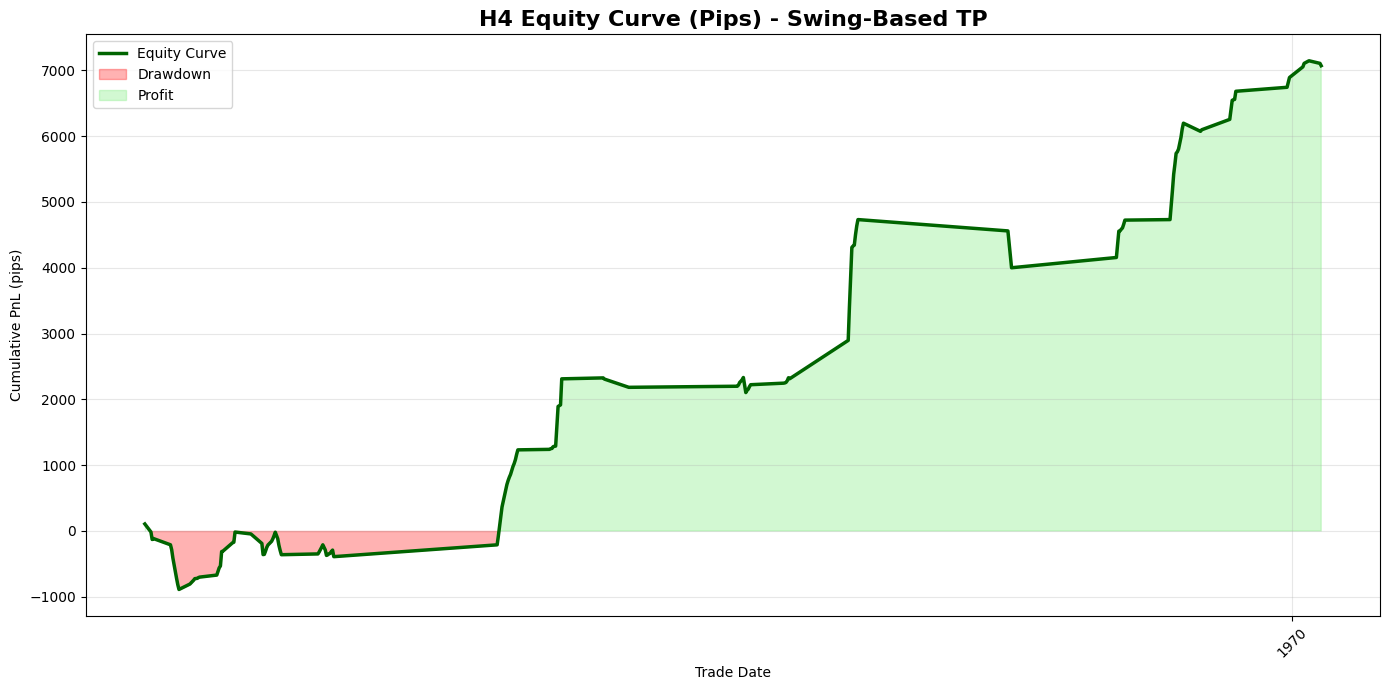


📌 Last 5 Trades (Swing TP):
                    timestamp direction   entry      sl      tp status      pnl
1970-01-01 00:00:00.000001009      bear 1.17385 1.17949 1.17220    win  0.00165
1970-01-01 00:00:00.000001010      bear 1.17426 1.17949 1.16904    win  0.00522
1970-01-01 00:00:00.000001014      bear 1.17302 1.17616 1.16904    win  0.00398
1970-01-01 00:00:00.000001023      bull 1.17357 1.16961 1.17925   loss -0.00396
1970-01-01 00:00:00.000001024      bull 1.17316 1.16961 1.17925   loss -0.00355


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# ======================
# 1. LOAD TRADES & H4 PRICE DATA
# ======================
print("📊 Loading H4 trades with swing-based TP for backtest...")

# Load the strategy-generated trades
try:
    trades_df = pd.read_csv("h4_wm_ob_swingtp_trades.csv")
    trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'])
    trades_df = trades_df.sort_values('timestamp').reset_index(drop=True)
except FileNotFoundError:
    print("❌ Error: 'h4_wm_ob_swingtp_trades.csv' not found. Run the H4 strategy first!")
    exit()

if trades_df.empty:
    print("❌ No trades to backtest.")
    exit()

# Re-download H4 data for accurate simulation
print("🔁 Downloading EUR/USD 4-hour (H4) price data...")
data_raw = yf.download("EURUSD=X", interval="4h", period="180d")

if data_raw.empty:
    print("❌ Failed to download H4 data.")
    exit()

# Handle MultiIndex (if present)
if isinstance(data_raw.columns, pd.MultiIndex):
    data_raw.columns = data_raw.columns.get_level_values(0)

# Keep essential columns
data_raw = data_raw[['Open', 'High', 'Low', 'Close']]
for col in ['Open', 'High', 'Low', 'Close']:
    data_raw[col] = pd.to_numeric(data_raw[col], errors='coerce')
data_raw.dropna(inplace=True)
data_raw.reset_index(inplace=True)
data_raw['timestamp'] = pd.to_datetime(data_raw['Date'] if 'Date' in data_raw else data_raw.index)

# ======================
# 2. SIMULATE EACH TRADE
# ======================
print(f"🚀 Backtesting {len(trades_df)} H4 trade(s) with swing-based TP...")

results = []

for _, trade in trades_df.iterrows():
    entry_time = trade['timestamp']
    entry_price = trade['entry']
    sl = trade['sl']
    tp = trade['tp']
    direction = trade['direction']

    # Find first candle on or after entry
    future_data = data_raw[data_raw['timestamp'] >= entry_time]
    if future_data.empty:
        results.append({**trade, 'status': 'invalid', 'pnl': 0, 'bars_held': 0})
        continue

    start_idx = future_data.index[0]

    # Simulate forward from entry candle
    status = "open"
    pnl = 0.0
    bars_held = 0

    for j in range(start_idx, len(data_raw)):
        candle = data_raw.iloc[j]
        high, low, close = candle['High'], candle['Low'], candle['Close']
        bars_held += 1

        if direction == 'bull':
            if low <= sl:
                pnl = -(entry_price - sl)
                status = 'loss'
                break
            elif high >= tp:
                pnl = tp - entry_price
                status = 'win'
                break
        elif direction == 'bear':
            if high >= sl:
                pnl = -(sl - entry_price)
                status = 'loss'
                break
            elif low <= tp:
                pnl = entry_price - tp
                status = 'win'
                break
    else:
        # Trade didn't hit SL/TP → exit at last close (partial)
        last_close = data_raw['Close'].iloc[-1]
        if direction == 'bull':
            pnl = last_close - entry_price
        else:
            pnl = entry_price - last_close
        status = 'partial'

    # Save result
    results.append({
        'timestamp': trade['timestamp'],
        'direction': direction,
        'entry': round(entry_price, 5),
        'sl': round(sl, 5),
        'tp': round(tp, 5),
        'status': status,
        'pnl': round(pnl, 5),
        'bars_held': bars_held
    })

# ======================
# 3. PERFORMANCE METRICS
# ======================
results_df = pd.DataFrame(results)
wins = results_df[results_df['status'] == 'win']
losses = results_df[results_df['status'] == 'loss']
partials = results_df[results_df['status'] == 'partial']

total_trades = len(results_df)
win_rate = len(wins) / total_trades * 100 if total_trades > 0 else 0
total_pnl = results_df['pnl'].sum()
win_pnl = wins['pnl'].sum()
loss_pnl = abs(losses['pnl'].sum())
profit_factor = win_pnl / loss_pnl if loss_pnl != 0 else float('inf')

# Convert to pips (EURUSD: 1.00000 = 10,000 pips)
results_df['pnl_pips'] = results_df['pnl'] * 10000
avg_pnl_pips = results_df['pnl_pips'].mean()

# Max Drawdown (equity curve)
results_df_sorted = results_df.sort_values('timestamp').copy()
results_df_sorted['cum_pnl'] = results_df_sorted['pnl'].cumsum()
cum_pnl = results_df_sorted['cum_pnl'].values
running_max = np.maximum.accumulate(cum_pnl)
drawdown = running_max - cum_pnl
max_drawdown_pips = drawdown.max() * 10000

# ======================
# 4. PRINT SUMMARY
# ======================
print("\n" + "="*55)
print("    📊 H4 BACKTEST: Swing-Level Take Profit")
print("="*55)
print(f"Total Trades        : {total_trades}")
print(f"Winning Trades      : {len(wins)}")
print(f"Losing Trades       : {len(losses)}")
print(f"Partial/Unfinished  : {len(partials)}")
print(f"Win Rate            : {win_rate:.1f}%")
print(f"Total PnL (pips)    : {total_pnl * 10000:.1f}")
print(f"Profit Factor       : {profit_factor:.2f}" if profit_factor != float('inf') else "Profit Factor       : ∞ (All Wins)")
print(f"Avg Win per Trade   : {avg_pnl_pips:.1f} pips")
print(f"Max Drawdown        : {max_drawdown_pips:.1f} pips")
print("="*55)

# ======================
# 5. SAVE DETAILED RESULTS
# ======================
results_df.to_csv("backtest_results_h4_swingtp.csv", index=False)
print(f"\n💾 Full results saved to 'backtest_results_h4_swingtp.csv'")

# ======================
# 6. PLOT EQUITY CURVE (Pips)
# ======================
plt.figure(figsize=(14, 7))
cum_pnl_pips = results_df_sorted['cum_pnl'] * 10000  # in pips
plt.plot(results_df_sorted['timestamp'], cum_pnl_pips, color='darkgreen', linewidth=2.5, label='Equity Curve')

# Fill below zero in red (drawdown), above in green
plt.fill_between(results_df_sorted['timestamp'], cum_pnl_pips, 0,
                 where=(cum_pnl_pips < 0), color='red', alpha=0.3, label='Drawdown')
plt.fill_between(results_df_sorted['timestamp'], cum_pnl_pips, 0,
                 where=(cum_pnl_pips >= 0), color='lightgreen', alpha=0.4, label='Profit')

plt.title("H4 Equity Curve (Pips) - Swing-Based TP", fontsize=16, fontweight='bold')
plt.ylabel("Cumulative PnL (pips)")
plt.xlabel("Trade Date")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ======================
# 7. SHOW LAST 5 TRADES
# ======================
print("\n📌 Last 5 Trades (Swing TP):")
print(results_df.tail(5)[[
    'timestamp', 'direction', 'entry', 'sl', 'tp', 'status', 'pnl'
]].to_string(index=False))

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings

warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD H4 DATA
# ======================
print("📥 Downloading GBP/USD 4-hour (H4) data...")
symbol = "GBPUSD=X"  # ←←← ONLY CHANGE: EURUSD=X → GBPUSD=X
data = yf.download(symbol, interval="4h", period="180d")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Handle MultiIndex
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in ['Open', 'High', 'Low', 'Close']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (PEAKS & TROUGHS)
# ======================
def find_swings(series, order=5):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return set(min_idx), set(max_idx)

min_idx_set, max_idx_set = find_swings(data['Low'], order=5)
min_idx_list = sorted([idx for idx in min_idx_set if idx < len(data)])
max_idx_list = sorted([idx for idx in max_idx_set if idx < len(data)])

# ======================
# 4. DETECT W PATTERN (Bullish Reversal)
# ======================
def is_w_pattern(data, i, min_indices, window=20):
    start = max(i - window, 0)
    recent_troughs = [idx for idx in min_indices if start <= idx < i]
    if len(recent_troughs) < 2:
        return False, None, None

    t1, t2 = recent_troughs[-2], recent_troughs[-1]

    # Price: second low ~equal or higher
    price_ok = data['Low'].iloc[t2] >= data['Low'].iloc[t1] * 0.995

    # RSI: bullish divergence
    rsi_t1 = data['RSI'].iloc[t1]
    rsi_t2 = data['RSI'].iloc[t2]
    rsi_ok = (rsi_t2 > rsi_t1) and (rsi_t1 < 50)

    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

# ======================
# 5. DETECT M PATTERN (Bearish Reversal)
# ======================
def is_m_pattern(data, i, max_indices, window=20):
    start = max(i - window, 0)
    recent_peaks = [idx for idx in max_indices if start <= idx < i]
    if len(recent_peaks) < 2:
        return False, None, None

    p1, p2 = recent_peaks[-2], recent_peaks[-1]

    # Price: second high ~equal or lower
    price_ok = data['High'].iloc[p2] <= data['High'].iloc[p1] * 1.005

    # RSI: bearish divergence
    rsi_p1 = data['RSI'].iloc[p1]
    rsi_p2 = data['RSI'].iloc[p2]
    rsi_ok = (rsi_p2 < rsi_p1) and (rsi_p1 > 50)

    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 6. IDENTIFY ORDER BLOCK (OB)
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    if len(window) == 0: return None
    ob_idx = window['Close'].idxmin()  # weakest close before breakout
    return data.loc[ob_idx]

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    if len(window) == 0: return None
    ob_idx = window['Close'].idxmax()  # strongest close before drop
    return data.loc[ob_idx]

# ======================
# 7. FIND NEAREST SWING HIGH/LOW (FOR TP)
# ======================
def find_prior_swing_high(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    if len(subset) == 0: return None
    return subset.max()

def find_prior_swing_low(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    if len(subset) == 0: return None
    return subset.min()

# ======================
# 8. TRADE LOGIC ENGINE (TP = SWING LEVEL)
# ======================
trades = []

print(f"🔍 Scanning {len(data)} H4 candles for W/M patterns (TP = Swing Level)...")

for i in range(40, len(data) - 5):
    # --- BULLISH: W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list, window=20)
    if is_w:
        t1, t2 = troughs
        if data['High'].iloc[i] > neckline_w:  # ChoCh confirmed
            ob = find_bullish_ob(data, t2, i)
            if ob is not None:
                entry_idx = i + 2
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0008  # buffer below OB

                # ✅ TP = Nearest prior swing high
                tp = find_prior_swing_high(data, i, lookback=25)
                if tp is None or tp <= entry:  # avoid invalid or too close
                    tp = entry + 2 * (entry - sl)  # fallback: 1:2 RR

                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(float(entry), 5),
                    'sl': round(float(sl), 5),
                    'tp': round(float(tp), 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- BEARISH: M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list, window=20)
    if is_m:
        p1, p2 = peaks
        if data['Low'].iloc[i] < neckline_m:  # ChoCh confirmed
            ob = find_bearish_ob(data, p2, i)
            if ob is not None:
                entry_idx = i + 2
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0008  # buffer above OB

                # ✅ TP = Nearest prior swing low
                tp = find_prior_swing_low(data, i, lookback=25)
                if tp is None or tp >= entry:  # avoid invalid
                    tp = entry - 2 * (sl - entry)  # fallback: 1:2 RR

                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(float(entry), 5),
                    'sl': round(float(sl), 5),
                    'tp': round(float(tp), 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. EXPORT TRADES
# ======================
trades_df = pd.DataFrame(trades)

if len(trades_df) > 0:
    trades_df.to_csv("h4_wm_ob_swingtp_trades.csv", index=False)
    print(f"✅ H4 Strategy complete! {len(trades_df)} trade(s) saved with swing-based TP.")
    print("\nLast 5 trades:")
    print(trades_df.tail(5).to_string(index=False))
else:
    print("❌ No valid H4 W/M + OB retest trades found.")

📥 Downloading GBP/USD 4-hour (H4) data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 1061 H4 candles for W/M patterns (TP = Swing Level)...
✅ H4 Strategy complete! 176 trade(s) saved with swing-based TP.

Last 5 trades:
                    timestamp   entry      sl      tp direction     setup                       ob_time
1970-01-01 00:00:00.000000965 1.37484 1.35841 1.37650      bull W_pattern 1970-01-01 00:00:00.000000957
1970-01-01 00:00:00.000000966 1.37223 1.35841 1.37650      bull W_pattern 1970-01-01 00:00:00.000000957
1970-01-01 00:00:00.000001067 1.34916 1.33948 1.36852      bull W_pattern 1970-01-01 00:00:00.000001062
1970-01-01 00:00:00.000001068 1.34891 1.33948 1.34960      bull W_pattern 1970-01-01 00:00:00.000001062
1970-01-01 00:00:00.000001069 1.34820 1.33948 1.35104      bull W_pattern 1970-01-01 00:00:00.000001062



📈 Starting backtest of identified trades...

📊 BACKTEST RESULTS
Total Trade Signals:     176
Completed Trades:        170
Wins:                    97
Losses:                  73
Win Rate:                57.1%
Avg Risk-Reward (RR):    1.48
Avg PnL per Trade:       +0.00080
Total PnL:               +0.14063


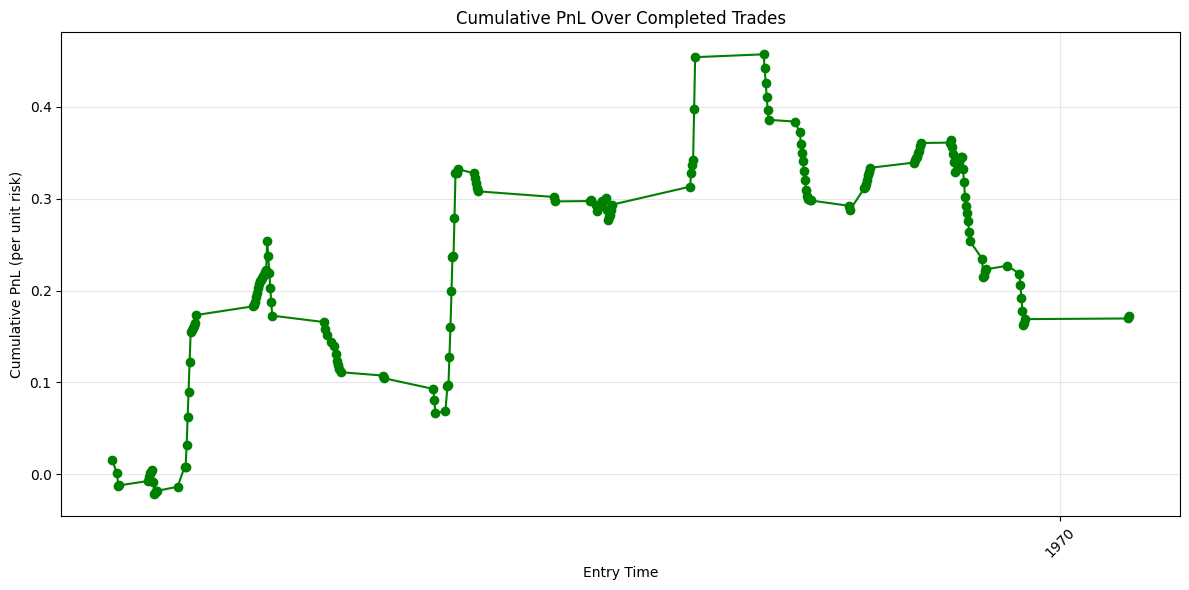


💾 Backtest results saved to 'h4_wm_ob_backtest_results.csv'
                   entry_time                     exit_time direction   entry      sl      tp  risk_per_unit  reward_per_unit    RR outcome      pnl  holding_period_days                       ob_time
1970-01-01 00:00:00.000000059 1970-01-01 00:00:00.000000072      bull 1.25458 1.25356 1.26971        0.00102          0.01513 14.83     win  0.01513                  0.0 1970-01-01 00:00:00.000000055
1970-01-01 00:00:00.000000064 1970-01-01 00:00:00.000000160      bull 1.26781 1.25356 1.29632        0.01425          0.02851  2.00    loss -0.01425                  0.0 1970-01-01 00:00:00.000000055
1970-01-01 00:00:00.000000065 1970-01-01 00:00:00.000000160      bull 1.26733 1.25356 1.29487        0.01377          0.02754  2.00    loss -0.01377                  0.0 1970-01-01 00:00:00.000000055
1970-01-01 00:00:00.000000066 1970-01-01 00:00:00.000000070      bull 1.26781 1.25356 1.26854        0.01425          0.00073  0.05     win

In [2]:
# ======================
# 10. BACKTEST TRADES
# ======================
print("\n📈 Starting backtest of identified trades...")

results = []

# We'll use the same data but ensure it has forward OHLC for simulation
price_data = data[['timestamp', 'Open', 'High', 'Low', 'Close']].copy()
price_data.set_index('timestamp', inplace=True)

for trade in trades:
    entry_time = trade['timestamp']
    direction = trade['direction']
    entry = trade['entry']
    sl = trade['sl']
    tp = trade['tp']
    ob_time = trade['ob_time']

    # Define risk per trade (e.g., 1 unit of currency)
    risk_per_unit = abs(entry - sl)
    reward_per_unit = abs(tp - entry)
    rr_ratio = reward_per_unit / risk_per_unit if risk_per_unit > 0 else 0

    # Find next candles after entry
    future_data = price_data[price_data.index > entry_time]

    outcome = 'running'
    exit_time = None
    pnl = 0.0

    for idx, row in future_data.iterrows():
        if direction == 'bull':
            if row['Low'] <= sl:
                outcome = 'loss'
                exit_time = idx
                pnl = -risk_per_unit
                break
            elif row['High'] >= tp:
                outcome = 'win'
                exit_time = idx
                pnl = reward_per_unit
                break
        elif direction == 'bear':
            if row['High'] >= sl:
                outcome = 'loss'
                exit_time = idx
                pnl = -risk_per_unit
                break
            elif row['Low'] <= tp:
                outcome = 'win'
                exit_time = idx
                pnl = reward_per_unit
                break

    # If no exit was triggered in available data
    if outcome == 'running':
        # Use last close as exit (partial or current)
        last_close = price_data['Close'].iloc[-1]
        if direction == 'bull':
            pnl = last_close - entry
        elif direction == 'bear':
            pnl = entry - last_close
        outcome = 'incomplete'
        exit_time = price_data.index[-1]

    results.append({
        'entry_time': entry_time,
        'exit_time': exit_time,
        'direction': direction,
        'entry': entry,
        'sl': sl,
        'tp': tp,
        'risk_per_unit': risk_per_unit,
        'reward_per_unit': reward_per_unit,
        'RR': round(rr_ratio, 2),
        'outcome': outcome,
        'pnl': round(pnl, 5),
        'holding_period_days': (pd.to_datetime(exit_time) - pd.to_datetime(entry_time)).total_seconds() / (60 * 60 * 24) if exit_time else None,
        'ob_time': ob_time
    })

# Create backtest results DataFrame
results_df = pd.DataFrame(results)

# ======================
# 11. PERFORMANCE SUMMARY
# ======================
total_trades = len(results_df)
completed_trades = len(results_df[results_df['outcome'].isin(['win', 'loss'])])
winning_trades = len(results_df[results_df['outcome'] == 'win'])
losing_trades = len(results_df[results_df['outcome'] == 'loss'])
win_rate = (winning_trades / completed_trades * 100) if completed_trades > 0 else 0
avg_rr = results_df['RR'].mean()
avg_pnl = results_df['pnl'].mean()
total_pnl = results_df['pnl'].sum()

print("\n" + "="*50)
print("📊 BACKTEST RESULTS")
print("="*50)
print(f"Total Trade Signals:     {total_trades}")
print(f"Completed Trades:        {completed_trades}")
print(f"Wins:                    {winning_trades}")
print(f"Losses:                  {losing_trades}")
print(f"Win Rate:                {win_rate:.1f}%")
print(f"Avg Risk-Reward (RR):    {avg_rr:.2f}")
print(f"Avg PnL per Trade:       {avg_pnl:+.5f}")
print(f"Total PnL:               {total_pnl:+.5f}")
print("="*50)

# Optional: Add cumulative PnL plot
import matplotlib.pyplot as plt

if not results_df.empty:
    results_df_sorted = results_df[results_df['outcome'].isin(['win', 'loss'])].sort_values('entry_time')
    results_df_sorted['cum_pnl'] = results_df_sorted['pnl'].cumsum()

    plt.figure(figsize=(12, 6))
    plt.plot(results_df_sorted['entry_time'], results_df_sorted['cum_pnl'], marker='o', linestyle='-', color='green' if total_pnl > 0 else 'red')
    plt.title('Cumulative PnL Over Completed Trades')
    plt.xlabel('Entry Time')
    plt.ylabel('Cumulative PnL (per unit risk)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ======================
# 12. SAVE RESULTS
# ======================
results_df.to_csv("h4_wm_ob_backtest_results.csv", index=False)
print(f"\n💾 Backtest results saved to 'h4_wm_ob_backtest_results.csv'")
print(results_df.head().to_string(index=False))

📥 Downloading XAU/USD 4-hour (H4) data...


[*********************100%***********************]  1 of 1 completed


📊 Retrieved 910 H4 candles for GC=F
🔍 Scanning 897 H4 candles for W/M patterns on XAU/USD...
✅ Found 101 trade(s). Saved to xauusd_h4_wm_ob_trades.csv
📈 Starting backtest for XAU/USD trades...

📊 XAU/USD BACKTEST RESULTS (H4 Timeframe)
Total Signals:           101
Completed Trades:        92
Wins:                    53
Losses:                  39
Win Rate:                57.6%
Avg Risk-Reward:         1.95
Avg PnL per Trade:       +13.9
Total PnL (USD):         +1407.5

💾 Results saved to 'xauusd_h4_wm_ob_backtest_results.csv'


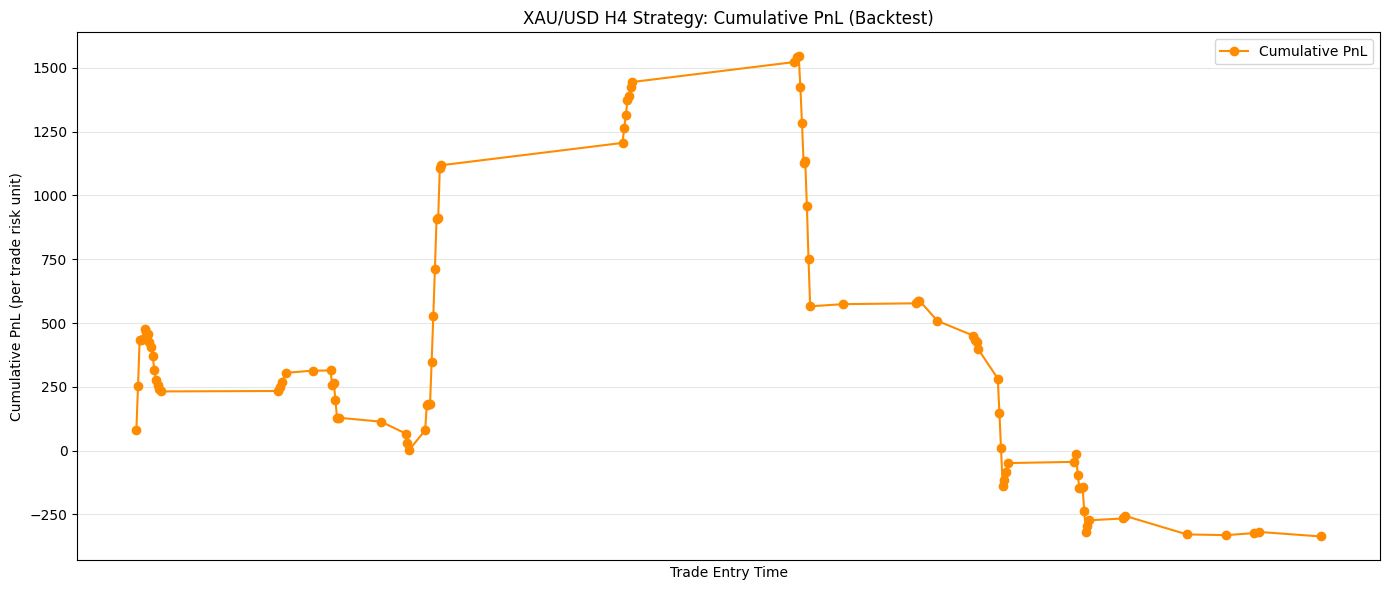


✅ XAU/USD strategy and backtest complete!


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD H4 DATA (XAU/USD)
# ======================
print("📥 Downloading XAU/USD 4-hour (H4) data...")
symbol = "GC=F"  # Primary Yahoo Finance symbol for Gold (futures). Alternative: "XAUUSD=X" if available
data = yf.download(symbol, interval="4h", period="180d")

if data.empty:
    print("❌ No data returned. Try 'GC=F' or check internet connection.")
    exit()

# Handle MultiIndex
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in ['Open', 'High', 'Low', 'Close']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

print(f"📊 Retrieved {len(data)} H4 candles for {symbol}")

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (PEAKS & TROUGHS)
# ======================
def find_swings(series, order=5):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return set(min_idx), set(max_idx)

min_idx_set, max_idx_set = find_swings(data['Low'], order=5)
min_idx_list = sorted([idx for idx in min_idx_set if idx < len(data)])
max_idx_list = sorted([idx for idx in max_idx_set if idx < len(data)])

# ======================
# 4. DETECT W PATTERN (Bullish Reversal)
# ======================
def is_w_pattern(data, i, min_indices, window=20):
    start = max(i - window, 0)
    recent_troughs = [idx for idx in min_indices if start <= idx < i]
    if len(recent_troughs) < 2:
        return False, None, None

    t1, t2 = recent_troughs[-2], recent_troughs[-1]

    # Price: second low ~equal or higher (within 0.3% for gold's noise)
    price_ok = data['Low'].iloc[t2] >= data['Low'].iloc[t1] * 0.997

    # RSI: bullish divergence (rising RSI at lower low)
    rsi_t1 = data['RSI'].iloc[t1]
    rsi_t2 = data['RSI'].iloc[t2]
    rsi_ok = (rsi_t2 > rsi_t1) and (rsi_t1 < 50)

    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

# ======================
# 5. DETECT M PATTERN (Bearish Reversal)
# ======================
def is_m_pattern(data, i, max_indices, window=20):
    start = max(i - window, 0)
    recent_peaks = [idx for idx in max_indices if start <= idx < i]
    if len(recent_peaks) < 2:
        return False, None, None

    p1, p2 = recent_peaks[-2], recent_peaks[-1]

    # Price: second high ~equal or lower
    price_ok = data['High'].iloc[p2] <= data['High'].iloc[p1] * 1.003

    # RSI: bearish divergence
    rsi_p1 = data['RSI'].iloc[p1]
    rsi_p2 = data['RSI'].iloc[p2]
    rsi_ok = (rsi_p2 < rsi_p1) and (rsi_p1 > 50)

    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 6. IDENTIFY ORDER BLOCK (OB)
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    if len(window) == 0: return None
    ob_idx = window['Close'].idxmin()
    return data.loc[ob_idx]

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    if len(window) == 0: return None
    ob_idx = window['Close'].idxmax()
    return data.loc[ob_idx]

# ======================
# 7. FIND NEAREST SWING HIGH/LOW (FOR TP)
# ======================
def find_prior_swing_high(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if len(subset) > 0 else None

def find_prior_swing_low(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if len(subset) > 0 else None

# ======================
# 8. TRADE LOGIC ENGINE (TP = SWING LEVEL)
# ======================
trades = []
print(f"🔍 Scanning {len(data)} H4 candles for W/M patterns on XAU/USD...")

for i in range(40, len(data) - 5):
    # --- BULLISH: W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list, window=20)
    if is_w:
        t1, t2 = troughs
        if data['High'].iloc[i] > neckline_w:  # Confirmation (ChoCh break)
            ob = find_bullish_ob(data, t2, i)
            if ob is not None:
                entry_idx = i + 2
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 5.0  # Gold: larger buffer (~$5), adjust based on volatility

                tp = find_prior_swing_high(data, i, lookback=25)
                if tp is None or tp <= entry:
                    tp = entry + 2 * (entry - sl)  # 1:2 RR fallback

                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(float(entry), 1),
                    'sl': round(float(sl), 1),
                    'tp': round(float(tp), 1),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- BEARISH: M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list, window=20)
    if is_m:
        p1, p2 = peaks
        if data['Low'].iloc[i] < neckline_m:  # ChoCh confirmed
            ob = find_bearish_ob(data, p2, i)
            if ob is not None:
                entry_idx = i + 2
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 5.0  # Buffer above OB

                tp = find_prior_swing_low(data, i, lookback=25)
                if tp is None or tp >= entry:
                    tp = entry - 2 * (sl - entry)  # 1:2 RR

                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(float(entry), 1),
                    'sl': round(float(sl), 1),
                    'tp': round(float(tp), 1),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. EXPORT RAW TRADES
# ======================
trades_df = pd.DataFrame(trades)
trade_filename = "xauusd_h4_wm_ob_trades.csv"
if len(trades_df) > 0:
    trades_df.to_csv(trade_filename, index=False)
    print(f"✅ Found {len(trades_df)} trade(s). Saved to {trade_filename}")
else:
    print("❌ No valid W/M + OB trades found for XAU/USD.")

# ======================
# 10. BACKTEST TRADES
# ======================
if len(trades_df) == 0:
    print("🚫 No trades to backtest.")
    exit()

print("📈 Starting backtest for XAU/USD trades...")

results = []
price_data = data[['timestamp', 'Open', 'High', 'Low', 'Close']].copy()
price_data.set_index('timestamp', inplace=True)

for trade in trades:
    entry_time = trade['timestamp']
    direction = trade['direction']
    entry = trade['entry']
    sl = trade['sl']
    tp = trade['tp']
    ob_time = trade['ob_time']

    risk_per_unit = abs(entry - sl)
    reward_per_unit = abs(tp - entry)
    rr_ratio = round(reward_per_unit / risk_per_unit, 2) if risk_per_unit > 0 else 0

    future_data = price_data[price_data.index > entry_time]
    outcome = 'running'
    exit_time = None
    pnl = 0.0

    for idx, row in future_data.iterrows():
        hit_sl = False
        hit_tp = False

        if direction == 'bull':
            if row['Low'] <= sl:
                hit_sl = True
            if row['High'] >= tp:
                hit_tp = True
            if hit_sl:
                outcome = 'loss'
                exit_time = idx
                pnl = -risk_per_unit
                break
            if hit_tp:
                outcome = 'win'
                exit_time = idx
                pnl = reward_per_unit
                break

        elif direction == 'bear':
            if row['High'] >= sl:
                hit_sl = True
            if row['Low'] <= tp:
                hit_tp = True
            if hit_sl:
                outcome = 'loss'
                exit_time = idx
                pnl = -risk_per_unit
                break
            if hit_tp:
                outcome = 'win'
                exit_time = idx
                pnl = reward_per_unit
                break

    if outcome == 'running':
        last_close = price_data['Close'].iloc[-1]
        if direction == 'bull':
            pnl = last_close - entry
        else:
            pnl = entry - last_close
        outcome = 'incomplete'
        exit_time = price_data.index[-1]

    results.append({
        'entry_time': entry_time,
        'exit_time': exit_time,
        'direction': direction,
        'entry': entry,
        'sl': sl,
        'tp': tp,
        'risk_per_unit': round(risk_per_unit, 1),
        'reward_per_unit': round(reward_per_unit, 1),
        'RR': rr_ratio,
        'outcome': outcome,
        'pnl': round(pnl, 1),
        'holding_period_days': (pd.to_datetime(exit_time) - pd.to_datetime(entry_time)).total_seconds() / (60*60*24) if exit_time else None,
        'ob_time': ob_time
    })

# Create results DataFrame
results_df = pd.DataFrame(results)

# ======================
# 11. PERFORMANCE SUMMARY
# ======================
total_trades = len(results_df)
completed = results_df[results_df['outcome'].isin(['win', 'loss'])]
completed_trades = len(completed)
winning_trades = len(completed[completed['outcome'] == 'win'])
losing_trades = len(completed[completed['outcome'] == 'loss'])
win_rate = (winning_trades / completed_trades * 100) if completed_trades > 0 else 0
avg_rr = results_df['RR'].mean()
avg_pnl = results_df['pnl'].mean()
total_pnl = results_df['pnl'].sum()

print("\n" + "="*55)
print("📊 XAU/USD BACKTEST RESULTS (H4 Timeframe)")
print("="*55)
print(f"Total Signals:           {total_trades}")
print(f"Completed Trades:        {completed_trades}")
print(f"Wins:                    {winning_trades}")
print(f"Losses:                  {losing_trades}")
print(f"Win Rate:                {win_rate:.1f}%")
print(f"Avg Risk-Reward:         {avg_rr:.2f}")
print(f"Avg PnL per Trade:       {avg_pnl:+.1f}")
print(f"Total PnL (USD):         {total_pnl:+.1f}")
print("="*55)

# ======================
# 12. SAVE & PLOT RESULTS
# ======================
result_filename = "xauusd_h4_wm_ob_backtest_results.csv"
results_df.to_csv(result_filename, index=False)
print(f"\n💾 Results saved to '{result_filename}'")

# Optional: Plot Cumulative PnL
if completed_trades > 0:
    completed_results = results_df[results_df['outcome'].isin(['win', 'loss'])].copy()
    completed_results = completed_results.sort_values('entry_time')
    completed_results['cum_pnl'] = completed_results['pnl'].cumsum()

    plt.figure(figsize=(14, 6))
    plt.plot(completed_results['entry_time'], completed_results['cum_pnl'],
             marker='o', linestyle='-', color='darkorange', label='Cumulative PnL')
    plt.title('XAU/USD H4 Strategy: Cumulative PnL (Backtest)')
    plt.ylabel('Cumulative PnL (per trade risk unit)')
    plt.xlabel('Trade Entry Time')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("📉 No completed trades to plot.")

print("\n✅ XAU/USD strategy and backtest complete!")

📥 Downloading EURNZD 4-hour (H4) data...


[*********************100%***********************]  1 of 1 completed


📊 Retrieved 1075 H4 candles for EURNZD=X
🔍 Scanning 1062 H4 candles for W/M patterns on EURNZD...
✅ Found 65 trade(s). Saved to eurnzd_h4_wm_ob_trades.csv
📈 Starting backtest for EURNZD trades...

📊 EURNZD BACKTEST RESULTS (H4 Timeframe)
Total Signals:           65
Completed Trades:        65
Wins:                    44
Losses:                  21
Win Rate:                67.7%
Avg Risk-Reward:         0.92
Avg PnL per Trade:       +0.00100
Total PnL:               +0.06493

💾 Results saved to 'eurnzd_h4_wm_ob_backtest_results.csv'


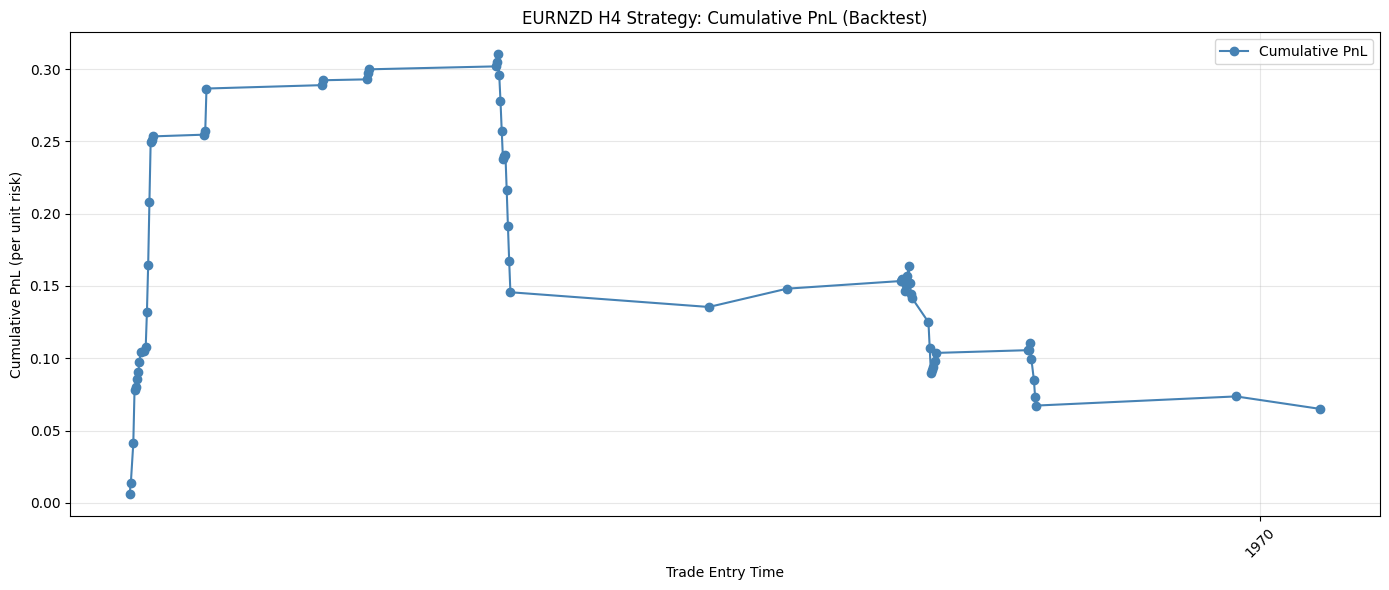


✅ EURNZD strategy and backtest complete!


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD H4 DATA (EURNZD)
# ======================
print("📥 Downloading EURNZD 4-hour (H4) data...")
symbol = "EURNZD=X"
data = yf.download(symbol, interval="4h", period="180d")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Handle MultiIndex (if data comes with multiple symbols)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Keep only relevant columns
data = data[['Open', 'High', 'Low', 'Close']]
for col in ['Open', 'High', 'Low', 'Close']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

print(f"📊 Retrieved {len(data)} H4 candles for {symbol}")

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (PEAKS & TROUGHS)
# ======================
def find_swings(series, order=5):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return set(min_idx), set(max_idx)

min_idx_set, max_idx_set = find_swings(data['Low'], order=5)
min_idx_list = sorted([idx for idx in min_idx_set if idx < len(data)])
max_idx_list = sorted([idx for idx in max_idx_set if idx < len(data)])

# ======================
# 4. DETECT W PATTERN (Bullish Reversal)
# ======================
def is_w_pattern(data, i, min_indices, window=20):
    start = max(i - window, 0)
    recent_troughs = [idx for idx in min_indices if start <= idx < i]
    if len(recent_troughs) < 2:
        return False, None, None

    t1, t2 = recent_troughs[-2], recent_troughs[-1]

    # Price: second low ~equal or higher (within 0.05% tolerance)
    price_ok = data['Low'].iloc[t2] >= data['Low'].iloc[t1] * 0.9995

    # RSI: bullish divergence
    rsi_t1 = data['RSI'].iloc[t1]
    rsi_t2 = data['RSI'].iloc[t2]
    rsi_ok = (rsi_t2 > rsi_t1) and (rsi_t1 < 50)

    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

# ======================
# 5. DETECT M PATTERN (Bearish Reversal)
# ======================
def is_m_pattern(data, i, max_indices, window=20):
    start = max(i - window, 0)
    recent_peaks = [idx for idx in max_indices if start <= idx < i]
    if len(recent_peaks) < 2:
        return False, None, None

    p1, p2 = recent_peaks[-2], recent_peaks[-1]

    # Price: second high ~equal or lower
    price_ok = data['High'].iloc[p2] <= data['High'].iloc[p1] * 1.0005

    # RSI: bearish divergence
    rsi_p1 = data['RSI'].iloc[p1]
    rsi_p2 = data['RSI'].iloc[p2]
    rsi_ok = (rsi_p2 < rsi_p1) and (rsi_p1 > 50)

    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 6. IDENTIFY ORDER BLOCK (OB)
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    if len(window) == 0:
        return None
    ob_idx = window['Close'].idxmin()  # weakest close before breakout
    return data.loc[ob_idx]

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    if len(window) == 0:
        return None
    ob_idx = window['Close'].idxmax()  # strongest close before drop
    return data.loc[ob_idx]

# ======================
# 7. FIND NEAREST SWING HIGH/LOW (FOR TP)
# ======================
def find_prior_swing_high(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if len(subset) > 0 else None

def find_prior_swing_low(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if len(subset) > 0 else None

# ======================
# 8. TRADE LOGIC ENGINE (TP = SWING LEVEL)
# ======================
trades = []
print(f"🔍 Scanning {len(data)} H4 candles for W/M patterns on EURNZD...")

for i in range(40, len(data) - 5):
    # --- BULLISH: W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list, window=20)
    if is_w:
        t1, t2 = troughs
        if data['High'].iloc[i] > neckline_w:  # Neckline breakout
            ob = find_bullish_ob(data, t2, i)
            if ob is not None:
                entry_idx = i + 2
                if entry_idx >= len(data):
                    continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0010  # ~100 pips buffer (adjustable)

                tp = find_prior_swing_high(data, i, lookback=25)
                if tp is None or tp <= entry:
                    tp = entry + 2 * (entry - sl)  # 1:2 RR fallback

                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(float(entry), 5),
                    'sl': round(float(sl), 5),
                    'tp': round(float(tp), 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- BEARISH: M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list, window=20)
    if is_m:
        p1, p2 = peaks
        if data['Low'].iloc[i] < neckline_m:  # Neckline break down
            ob = find_bearish_ob(data, p2, i)
            if ob is not None:
                entry_idx = i + 2
                if entry_idx >= len(data):
                    continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0010  # ~100 pips buffer

                tp = find_prior_swing_low(data, i, lookback=25)
                if tp is None or tp >= entry:
                    tp = entry - 2 * (sl - entry)  # 1:2 RR

                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(float(entry), 5),
                    'sl': round(float(sl), 5),
                    'tp': round(float(tp), 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. EXPORT RAW TRADES
# ======================
trades_df = pd.DataFrame(trades)
trade_filename = "eurnzd_h4_wm_ob_trades.csv"
if len(trades_df) > 0:
    trades_df.to_csv(trade_filename, index=False)
    print(f"✅ Found {len(trades_df)} trade(s). Saved to {trade_filename}")
else:
    print("❌ No valid W/M + OB trades found for EURNZD.")

# ======================
# 10. BACKTEST TRADES
# ======================
if len(trades_df) == 0:
    print("🚫 No trades to backtest.")
    exit()

print("📈 Starting backtest for EURNZD trades...")

results = []
price_data = data[['timestamp', 'Open', 'High', 'Low', 'Close']].copy()
price_data.set_index('timestamp', inplace=True)

for trade in trades:
    entry_time = trade['timestamp']
    direction = trade['direction']
    entry = trade['entry']
    sl = trade['sl']
    tp = trade['tp']
    ob_time = trade['ob_time']

    risk_per_unit = abs(entry - sl)
    reward_per_unit = abs(tp - entry)
    rr_ratio = round(reward_per_unit / risk_per_unit, 2) if risk_per_unit > 0 else 0

    future_data = price_data[price_data.index > entry_time]
    outcome = 'running'
    exit_time = None
    pnl = 0.0

    for idx, row in future_data.iterrows():
        if direction == 'bull':
            if row['Low'] <= sl:
                outcome = 'loss'
                exit_time = idx
                pnl = -risk_per_unit
                break
            elif row['High'] >= tp:
                outcome = 'win'
                exit_time = idx
                pnl = reward_per_unit
                break
        elif direction == 'bear':
            if row['High'] >= sl:
                outcome = 'loss'
                exit_time = idx
                pnl = -risk_per_unit
                break
            elif row['Low'] <= tp:
                outcome = 'win'
                exit_time = idx
                pnl = reward_per_unit
                break

    if outcome == 'running':
        last_close = price_data['Close'].iloc[-1]
        if direction == 'bull':
            pnl = last_close - entry
        else:
            pnl = entry - last_close
        outcome = 'incomplete'
        exit_time = price_data.index[-1]

    results.append({
        'entry_time': entry_time,
        'exit_time': exit_time,
        'direction': direction,
        'entry': entry,
        'sl': sl,
        'tp': tp,
        'risk_per_unit': round(risk_per_unit, 5),
        'reward_per_unit': round(reward_per_unit, 5),
        'RR': rr_ratio,
        'outcome': outcome,
        'pnl': round(pnl, 5),
        'holding_period_days': (pd.to_datetime(exit_time) - pd.to_datetime(entry_time)).total_seconds() / (60*60*24) if exit_time else None,
        'ob_time': ob_time
    })

# Create results DataFrame
results_df = pd.DataFrame(results)

# ======================
# 11. PERFORMANCE SUMMARY
# ======================
total_trades = len(results_df)
completed = results_df[results_df['outcome'].isin(['win', 'loss'])]
completed_trades = len(completed)
winning_trades = len(completed[completed['outcome'] == 'win'])
losing_trades = len(completed[completed['outcome'] == 'loss'])
win_rate = (winning_trades / completed_trades * 100) if completed_trades > 0 else 0
avg_rr = results_df['RR'].mean()
avg_pnl = results_df['pnl'].mean()
total_pnl = results_df['pnl'].sum()

print("\n" + "="*55)
print("📊 EURNZD BACKTEST RESULTS (H4 Timeframe)")
print("="*55)
print(f"Total Signals:           {total_trades}")
print(f"Completed Trades:        {completed_trades}")
print(f"Wins:                    {winning_trades}")
print(f"Losses:                  {losing_trades}")
print(f"Win Rate:                {win_rate:.1f}%")
print(f"Avg Risk-Reward:         {avg_rr:.2f}")
print(f"Avg PnL per Trade:       {avg_pnl:+.5f}")
print(f"Total PnL:               {total_pnl:+.5f}")
print("="*55)

# ======================
# 12. SAVE & PLOT RESULTS
# ======================
result_filename = "eurnzd_h4_wm_ob_backtest_results.csv"
results_df.to_csv(result_filename, index=False)
print(f"\n💾 Results saved to '{result_filename}'")

# Plot Cumulative PnL (only completed trades)
if completed_trades > 0:
    completed_results = results_df[results_df['outcome'].isin(['win', 'loss'])].sort_values('entry_time')
    completed_results['cum_pnl'] = completed_results['pnl'].cumsum()

    plt.figure(figsize=(14, 6))
    plt.plot(completed_results['entry_time'], completed_results['cum_pnl'],
             marker='o', linestyle='-', color='steelblue', label='Cumulative PnL')
    plt.title('EURNZD H4 Strategy: Cumulative PnL (Backtest)')
    plt.ylabel('Cumulative PnL (per unit risk)')
    plt.xlabel('Trade Entry Time')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("📉 No completed trades to plot.")

print("\n✅ EURNZD strategy and backtest complete!")

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD H4 DATA
# ======================
print("\U0001F4C5 Downloading EUR/USD 4-hour (H4) data...")
symbol = "EURUSD=X"
data = yf.download(symbol, interval="4h", period="180d")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS
# ======================
def find_swings(series, order=5):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=5)

# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=20):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.995
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 3)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=20):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.005
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 3)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. TRADE LOGIC
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(40, len(data) - 2):
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0008
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 1.5:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0008
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 1.5:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 8. EXPORT
# ======================
trades_df = pd.DataFrame(trades)

if not trades_df.empty:
    trades_df.to_csv("h4_wm_ob_swingtp_filtered_trades.csv", index=False)
    print(f"✅ Strategy complete! {len(trades_df)} trades saved.")
    print(trades_df.tail(5).to_string(index=False))
else:
    print("❌ No trades qualified.")


📅 Downloading EUR/USD 4-hour (H4) data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 1062 candles for W/M setups...
✅ Strategy complete! 6 trades saved.
                    timestamp   entry      sl      tp direction     setup                       ob_time
1970-01-01 00:00:00.000000170 1.04167 1.03397 1.05341      bull W_pattern 1970-01-01 00:00:00.000000163
1970-01-01 00:00:00.000000225 1.03295 1.03858 1.02375      bear M_pattern 1970-01-01 00:00:00.000000212
1970-01-01 00:00:00.000000347 1.03178 1.02075 1.05352      bull W_pattern 1970-01-01 00:00:00.000000345
1970-01-01 00:00:00.000000348 1.02870 1.02075 1.05097      bull W_pattern 1970-01-01 00:00:00.000000345
1970-01-01 00:00:00.000001023 1.17357 1.16865 1.18133      bull W_pattern 1970-01-01 00:00:00.000001018


In [7]:
import pandas as pd

# Load the generated trades CSV
trades_df = pd.read_csv("h4_wm_ob_swingtp_trades.csv")

# Backtest settings
initial_balance = 10000
risk_per_trade = 0.01  # 1%

# Initialize performance tracking
balance = initial_balance
pnl_list = []
risk_list = []
win_count = 0
loss_count = 0

for idx, trade in trades_df.iterrows():
    entry = trade['entry']
    sl = trade['sl']
    tp = trade['tp']
    direction = trade['direction']

    if direction == 'bull':
        risk = abs(entry - sl)
        reward = abs(tp - entry)
        outcome = reward >= risk  # simplified assumption: TP hit
    else:
        risk = abs(sl - entry)
        reward = abs(entry - tp)
        outcome = reward >= risk

    dollar_risk = risk_per_trade * balance
    lot_size = dollar_risk / risk if risk != 0 else 0
    profit = reward * lot_size if outcome else -risk * lot_size

    balance += profit
    pnl_list.append(profit)
    risk_list.append(risk)

    if profit > 0:
        win_count += 1
    else:
        loss_count += 1

# Final stats
total_trades = len(pnl_list)
win_rate = (win_count / total_trades) * 100 if total_trades > 0 else 0
avg_pnl = sum(pnl_list) / total_trades if total_trades > 0 else 0

print("\n📊 Backtest Results:")
print(f"Initial Balance: ${initial_balance:,.2f}")
print(f"Final Balance:   ${balance:,.2f}")
print(f"Total Trades:    {total_trades}")
print(f"Wins:            {win_count}")
print(f"Losses:          {loss_count}")
print(f"Win Rate:        {win_rate:.2f}%")
print(f"Avg PnL/Trade:   ${avg_pnl:.2f}")



📊 Backtest Results:
Initial Balance: $10,000.00
Final Balance:   $33,620.92
Total Trades:    176
Wins:            78
Losses:          98
Win Rate:        44.32%
Avg PnL/Trade:   $134.21


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD H4 DATA
# ======================
print("\U0001F4C5 Downloading EUR/USD 4-hour (H4) data...")
symbol = "EURUSD=X"
data = yf.download(symbol, interval="4h", period="180d")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS
# ======================
def find_swings(series, order=5):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=5)

# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=20):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.995
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 3)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=20):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.005
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 3)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. TRADE LOGIC
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(40, len(data) - 2):
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0008
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 2:  # Changed from 1.5 to 2
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0008
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 2:  # Changed from 1.5 to 2
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 8. EXPORT
# ======================
trades_df = pd.DataFrame(trades)

if not trades_df.empty:
    trades_df.to_csv("h4_wm_ob_swingtp_filtered_trades.csv", index=False)
    print(f"✅ Strategy complete! {len(trades_df)} trades saved.")
    print(trades_df.tail(5).to_string(index=False))
else:
    print("❌ No trades qualified.")

📅 Downloading EUR/USD 4-hour (H4) data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 1062 candles for W/M setups...
✅ Strategy complete! 2 trades saved.
                    timestamp   entry      sl      tp direction     setup                       ob_time
1970-01-01 00:00:00.000000058 1.04855 1.04228 1.06123      bull W_pattern 1970-01-01 00:00:00.000000054
1970-01-01 00:00:00.000000348 1.02870 1.02075 1.05097      bull W_pattern 1970-01-01 00:00:00.000000345


📅 Downloading EUR/USD 4-hour (H4) data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 1062 candles for W/M setups...
📊 Backtesting 2 trades...

📊 BACKTESTING RESULTS
Initial Capital: $10,000.00
Final Capital: $10,987.38
Total Return: $987.38 (9.87%)
Total Trades: 2
Win Rate: 100.0%
Winning Trades: 2
Losing Trades: 0
Average Win: $493.69
Average Loss: $0.00
Profit Factor: inf
Max Drawdown: 0.00%

✅ Detailed results saved to 'backtest_detailed_results.csv'

📋 Last 5 Trades:
                    timestamp direction   entry      sl      tp    pnl  rr_ratio exit_reason
1970-01-01 00:00:00.000000058      bull 1.04855 1.04228 1.06123 404.47      2.02          TP
1970-01-01 00:00:00.000000348      bull 1.02870 1.02075 1.05097 582.91      2.80          TP
📈 Equity curve saved as 'equity_curve.png'


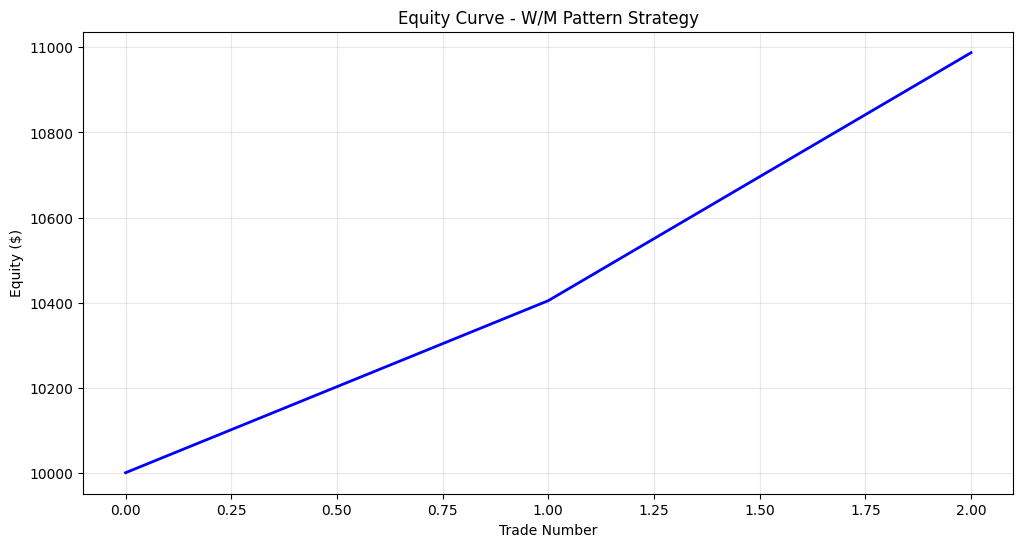

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD H4 DATA
# ======================
print("\U0001F4C5 Downloading EUR/USD 4-hour (H4) data...")
symbol = "EURUSD=X"
data = yf.download(symbol, interval="4h", period="180d")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS
# ======================
def find_swings(series, order=5):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=5)

# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=20):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.995
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 3)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=20):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.005
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 3)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, data, initial_capital=10000, risk_percent=2):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
        
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        
        if risk_per_unit == 0:
            return 0
        
        position_size = risk_amount / risk_per_unit
        return position_size
    
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        entry_idx = self.data[self.data['timestamp'] == trade_setup['timestamp']].index[0]
        
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
            
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(self.data)):
            current_candle = self.data.iloc[i]
            
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(self.data):
            final_candle = self.data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC (SAME AS BEFORE)
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(40, len(data) - 2):
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0008
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0008
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. BACKTEST EXECUTION
# ======================
if trades:
    print(f"\U0001F4CA Backtesting {len(trades)} trades...")
    
    # Initialize backtester
    backtester = Backtester(data, initial_capital=10000, risk_percent=2)
    
    # Execute all trades
    for trade in trades:
        backtester.execute_trade(trade)
    
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Print results
        print("\n" + "="*50)
        print("📊 BACKTESTING RESULTS")
        print("="*50)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        
        # Save detailed results
        trade_results.to_csv("backtest_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'backtest_detailed_results.csv'")
        
        # Show last 5 trades
        print("\n📋 Last 5 Trades:")
        print(trade_results[['timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail().to_string(index=False))
        
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Optional)
# ======================
try:
    import matplotlib.pyplot as plt
    
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - W/M Pattern Strategy')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('equity_curve.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'equity_curve.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

📅 Downloading EUR/USD 30-minute data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 2776 candles for W/M setups...
📊 Backtesting 43 trades...

📊 BACKTESTING RESULTS - 30-MINUTE TIMEFRAME
Initial Capital: $10,000.00
Final Capital: $8,722.41
Total Return: $-1,277.59 (-12.78%)
Total Trades: 43
Win Rate: 18.6%
Winning Trades: 8
Losing Trades: 35
Average Win: $493.71
Average Loss: $-149.35
Profit Factor: 0.76
Max Drawdown: -12.78%

✅ Detailed results saved to 'backtest_30min_detailed_results.csv'

📋 Last 5 Trades:
                    timestamp direction   entry      sl      tp     pnl  rr_ratio exit_reason
1970-01-01 00:00:00.000002517      bull 1.16713 1.16605 1.16986 -141.11      2.53          SL
1970-01-01 00:00:00.000002560      bull 1.16090 1.15983 1.16822 -138.99      6.84          SL
1970-01-01 00:00:00.000002561      bull 1.16131 1.15983 1.16700 -136.90      3.84          SL
1970-01-01 00:00:00.000002562      bull 1.16090 1.15983 1.16428 -134.85      3.16          SL
1970-01-01 00:00:00.000002611      bear 1.16279 1.16468 1.15674 -132.83      3.20       

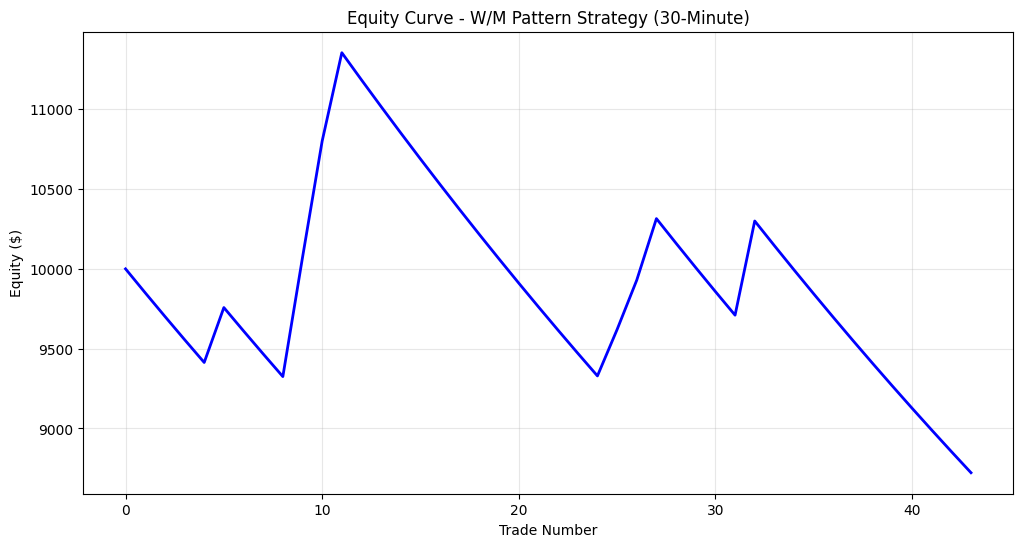

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD 30-MINUTE DATA
# ======================
print("\U0001F4C5 Downloading EUR/USD 30-minute data...")
symbol = "EURUSD=X"
data = yf.download(symbol, interval="30m", period="60d")  # Reduced period for 30m data

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (Adjusted for 30m timeframe)
# ======================
def find_swings(series, order=3):  # Reduced order for higher frequency data
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=3)

# ======================
# 4. PATTERN DETECTION (Adjusted window for 30m)
# ======================
def is_w_pattern(data, i, min_indices, window=15):  # Reduced window for 30m
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.998  # Tighter tolerance for 30m
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2)  # Lower RSI divergence threshold
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):  # Reduced window for 30m
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.002  # Tighter tolerance for 30m
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2)  # Lower RSI divergence threshold
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION (Adjusted for 30m)
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP (Adjusted lookback for 30m)
# ======================
def find_prior_swing_high(data, from_idx, lookback=20):  # Reduced lookback for 30m
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=20):  # Reduced lookback for 30m
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, data, initial_capital=10000, risk_percent=1.5):  # Reduced risk for 30m
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
        
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        
        if risk_per_unit == 0:
            return 0
        
        position_size = risk_amount / risk_per_unit
        return position_size
    
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        entry_idx = self.data[self.data['timestamp'] == trade_setup['timestamp']].index[0]
        
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
            
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(self.data)):
            current_candle = self.data.iloc[i]
            
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(self.data):
            final_candle = self.data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(20, len(data) - 2):  # Reduced lookback window
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0004  # Reduced SL for 30m timeframe
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0004  # Reduced SL for 30m timeframe
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. BACKTEST EXECUTION
# ======================
if trades:
    print(f"\U0001F4CA Backtesting {len(trades)} trades...")
    
    # Initialize backtester
    backtester = Backtester(data, initial_capital=10000, risk_percent=1.5)  # Reduced risk for 30m
    
    # Execute all trades
    for trade in trades:
        backtester.execute_trade(trade)
    
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Print results
        print("\n" + "="*50)
        print("📊 BACKTESTING RESULTS - 30-MINUTE TIMEFRAME")
        print("="*50)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        
        # Save detailed results
        trade_results.to_csv("backtest_30min_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'backtest_30min_detailed_results.csv'")
        
        # Show last 5 trades
        print("\n📋 Last 5 Trades:")
        print(trade_results[['timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail().to_string(index=False))
        
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Optional)
# ======================
try:
    import matplotlib.pyplot as plt
    
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - W/M Pattern Strategy (30-Minute)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('equity_curve_30min.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'equity_curve_30min.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

📅 Downloading EUR/USD 1-hour data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 2100 candles for W/M setups...
📊 Backtesting 48 trades...

📊 BACKTESTING RESULTS - 1-HOUR TIMEFRAME
Initial Capital: $10,000.00
Final Capital: $21,896.72
Total Return: $11,896.74 (118.97%)
Total Trades: 48
Win Rate: 50.0%
Winning Trades: 24
Losing Trades: 23
Average Win: $774.63
Average Loss: $-291.06
Profit Factor: 2.78
Max Drawdown: 0.00%

✅ Detailed results saved to 'backtest_1h_detailed_results.csv'

📋 Last 5 Trades:
                    timestamp direction   entry      sl      tp     pnl  rr_ratio exit_reason
1970-01-01 00:00:00.000002094      bear 1.16932 1.17036 1.16184 -423.84      7.19          SL
1970-01-01 00:00:00.000002095      bear 1.16932 1.17036 1.16239 -416.21      6.66          SL
1970-01-01 00:00:00.000002097      bear 1.16918 1.17036 1.16320 -408.72      5.07          SL
1970-01-01 00:00:00.000002098      bear 1.16918 1.17036 1.16333 -401.37      4.96          SL
1970-01-01 00:00:00.000002099      bear 1.16891 1.17036 1.16374    0.00      0.00        None


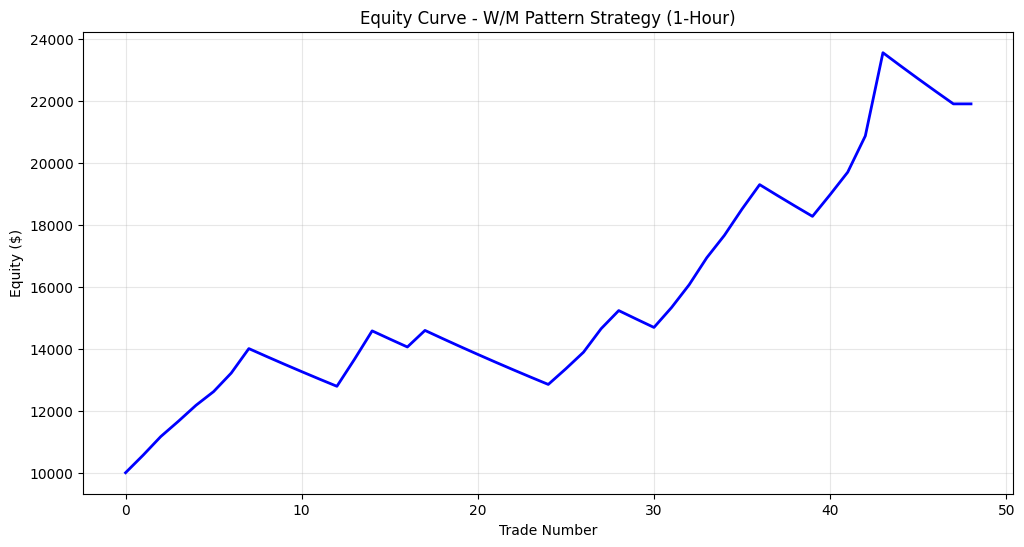

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD 1-HOUR DATA
# ======================
print("\U0001F4C5 Downloading EUR/USD 1-hour data...")
symbol = "EURUSD=X"
data = yf.download(symbol, interval="1h", period="90d")  # Period optimized for 1h data

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (Optimized for 1h timeframe)
# ======================
def find_swings(series, order=3):  # Lower order for higher frequency 1h data
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=3)

# ======================
# 4. PATTERN DETECTION (Optimized for 1h)
# ======================
def is_w_pattern(data, i, min_indices, window=15):  # Tighter window for 1h
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997  # Tighter tolerance for 1h
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)  # Moderate RSI divergence
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):  # Tighter window for 1h
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003  # Tighter tolerance for 1h
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)  # Moderate RSI divergence
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP (Optimized for 1h)
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):  # Balanced lookback for 1h
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=22):  # Balanced lookback for 1h
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, data, initial_capital=10000, risk_percent=1.8):  # Slightly reduced risk for 1h
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
        
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        
        if risk_per_unit == 0:
            return 0
        
        position_size = risk_amount / risk_per_unit
        return position_size
    
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        entry_idx = self.data[self.data['timestamp'] == trade_setup['timestamp']].index[0]
        
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
            
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(self.data)):
            current_candle = self.data.iloc[i]
            
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(self.data):
            final_candle = self.data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(25, len(data) - 2):  # Balanced lookback for 1h
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0005  # Moderate SL for 1h timeframe
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0005  # Moderate SL for 1h timeframe
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. BACKTEST EXECUTION
# ======================
if trades:
    print(f"\U0001F4CA Backtesting {len(trades)} trades...")
    
    # Initialize backtester
    backtester = Backtester(data, initial_capital=10000, risk_percent=1.8)  # Slightly reduced risk for 1h
    
    # Execute all trades
    for trade in trades:
        backtester.execute_trade(trade)
    
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Print results
        print("\n" + "="*50)
        print("📊 BACKTESTING RESULTS - 1-HOUR TIMEFRAME")
        print("="*50)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        
        # Save detailed results
        trade_results.to_csv("backtest_1h_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'backtest_1h_detailed_results.csv'")
        
        # Show last 5 trades
        print("\n📋 Last 5 Trades:")
        print(trade_results[['timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail().to_string(index=False))
        
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Optional)
# ======================
try:
    import matplotlib.pyplot as plt
    
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - W/M Pattern Strategy (1-Hour)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('equity_curve_1h.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'equity_curve_1h.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

📅 Downloading NZD/USD 1-hour data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 2102 candles for W/M setups...
📊 Backtesting 17 trades...

📊 BACKTESTING RESULTS - NZD/USD 1-HOUR TIMEFRAME
Initial Capital: $10,000.00
Final Capital: $14,102.48
Total Return: $4,102.49 (41.02%)
Total Trades: 17
Win Rate: 52.9%
Winning Trades: 9
Losing Trades: 8
Average Win: $637.22
Average Loss: $-204.06
Profit Factor: 3.51
Max Drawdown: -1.92%

✅ Detailed results saved to 'backtest_nzdusd_1h_detailed_results.csv'

📋 Last 5 Trades:
                    timestamp direction   entry      sl      tp     pnl  rr_ratio exit_reason
1970-01-01 00:00:00.000000635      bull 0.59652 0.59481 0.60028 -238.30      2.20          SL
1970-01-01 00:00:00.000000641      bull 0.59634 0.59481 0.60028 -234.01      2.58          SL
1970-01-01 00:00:00.000000698      bull 0.59344 0.59206 0.59805 -229.80      3.34          SL
1970-01-01 00:00:00.000000908      bull 0.58713 0.58450 0.59361  556.01      2.46          TP
1970-01-01 00:00:00.000001800      bear 0.60753 0.60848 0.60346 1009.66      4.28 

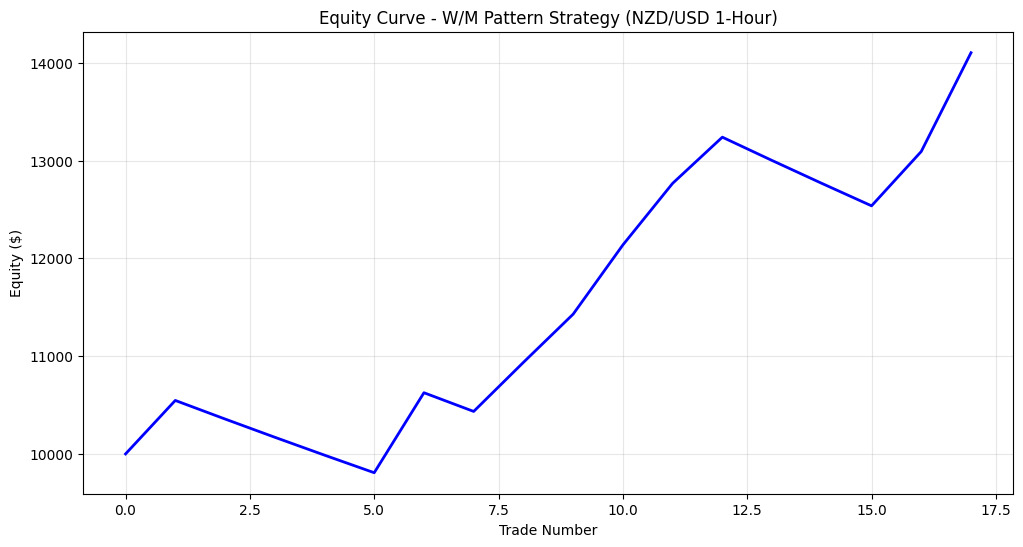

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD 1-HOUR DATA FOR NZD/USD
# ======================
print("\U0001F4C5 Downloading NZD/USD 1-hour data...")
symbol = "NZDUSD=X"
data = yf.download(symbol, interval="1h", period="90d")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (Optimized for 1h timeframe)
# ======================
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=3)

# ======================
# 4. PATTERN DETECTION (Optimized for 1h NZD/USD)
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP (Optimized for 1h)
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, data, initial_capital=10000, risk_percent=1.8):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
        
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        
        if risk_per_unit == 0:
            return 0
        
        position_size = risk_amount / risk_per_unit
        return position_size
    
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        entry_idx = self.data[self.data['timestamp'] == trade_setup['timestamp']].index[0]
        
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
            
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(self.data)):
            current_candle = self.data.iloc[i]
            
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(self.data):
            final_candle = self.data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(25, len(data) - 2):
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0005
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0005
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. BACKTEST EXECUTION
# ======================
if trades:
    print(f"\U0001F4CA Backtesting {len(trades)} trades...")
    
    # Initialize backtester
    backtester = Backtester(data, initial_capital=10000, risk_percent=1.8)
    
    # Execute all trades
    for trade in trades:
        backtester.execute_trade(trade)
    
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Print results
        print("\n" + "="*50)
        print("📊 BACKTESTING RESULTS - NZD/USD 1-HOUR TIMEFRAME")
        print("="*50)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        
        # Save detailed results
        trade_results.to_csv("backtest_nzdusd_1h_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'backtest_nzdusd_1h_detailed_results.csv'")
        
        # Show last 5 trades
        print("\n📋 Last 5 Trades:")
        print(trade_results[['timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail().to_string(index=False))
        
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Optional)
# ======================
try:
    import matplotlib.pyplot as plt
    
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - W/M Pattern Strategy (NZD/USD 1-Hour)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('equity_curve_nzdusd_1h.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'equity_curve_nzdusd_1h.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

📅 Downloading USD/JPY 1-hour data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 2088 candles for W/M setups...
📊 Backtesting 30 trades...

📊 BACKTESTING RESULTS - USD/JPY 1-HOUR TIMEFRAME
Initial Capital: $10,000.00
Final Capital: $10,331.71
Total Return: $331.73 (3.32%)
Total Trades: 30
Win Rate: 26.7%
Winning Trades: 8
Losing Trades: 22
Average Win: $576.81
Average Loss: $-194.67
Profit Factor: 1.08
Max Drawdown: -7.01%

✅ Detailed results saved to 'backtest_usdjpy_1h_detailed_results.csv'

📋 Last 5 Trades:
                    timestamp direction     entry       sl        tp     pnl  rr_ratio exit_reason
1970-01-01 00:00:00.000001995      bear 148.88200 149.1865 147.60600  779.26      4.19          TP
1970-01-01 00:00:00.000002082      bull 147.48199 147.2885 148.57600 -199.99      5.65          SL
1970-01-01 00:00:00.000002083      bull 147.57899 147.2885 148.55901 -196.39      3.37          SL
1970-01-01 00:00:00.000002084      bull 147.46400 147.2885 148.53999 -192.85      6.13          SL
1970-01-01 00:00:00.000002085      bull 147.57401 147.2885 

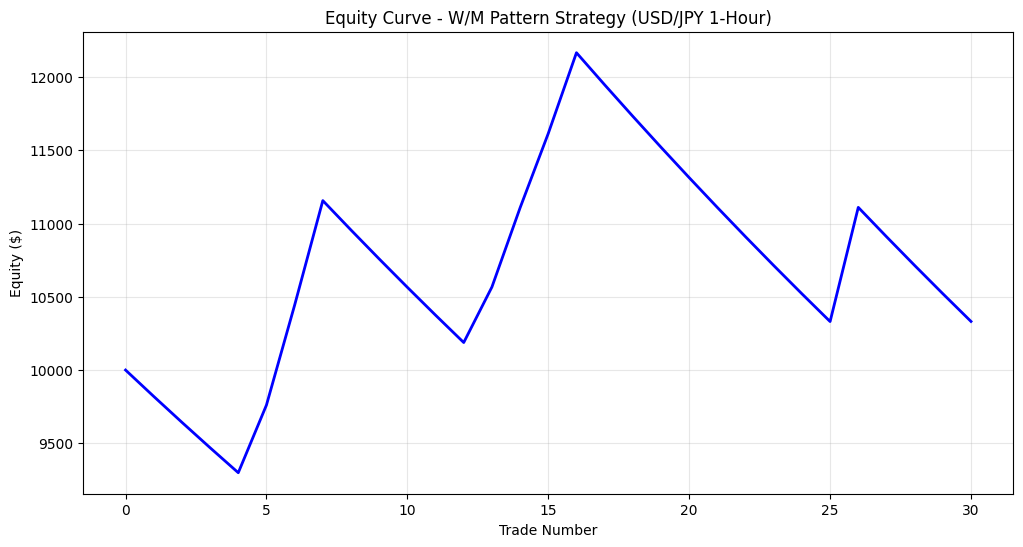

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD 1-HOUR DATA FOR USD/JPY
# ======================
print("\U0001F4C5 Downloading USD/JPY 1-hour data...")
symbol = "USDJPY=X"
data = yf.download(symbol, interval="1h", period="90d")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (Optimized for 1h timeframe)
# ======================
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=3)

# ======================
# 4. PATTERN DETECTION (Optimized for 1h USD/JPY)
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP (Optimized for 1h)
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, data, initial_capital=10000, risk_percent=1.8):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
        
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        
        if risk_per_unit == 0:
            return 0
        
        position_size = risk_amount / risk_per_unit
        return position_size
    
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        entry_idx = self.data[self.data['timestamp'] == trade_setup['timestamp']].index[0]
        
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
            
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(self.data)):
            current_candle = self.data.iloc[i]
            
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(self.data):
            final_candle = self.data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(25, len(data) - 2):
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0005
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0005
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. BACKTEST EXECUTION
# ======================
if trades:
    print(f"\U0001F4CA Backtesting {len(trades)} trades...")
    
    # Initialize backtester
    backtester = Backtester(data, initial_capital=10000, risk_percent=1.8)
    
    # Execute all trades
    for trade in trades:
        backtester.execute_trade(trade)
    
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Print results
        print("\n" + "="*50)
        print("📊 BACKTESTING RESULTS - USD/JPY 1-HOUR TIMEFRAME")
        print("="*50)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        
        # Save detailed results
        trade_results.to_csv("backtest_usdjpy_1h_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'backtest_usdjpy_1h_detailed_results.csv'")
        
        # Show last 5 trades
        print("\n📋 Last 5 Trades:")
        print(trade_results[['timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail().to_string(index=False))
        
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Optional)
# ======================
try:
    import matplotlib.pyplot as plt
    
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - W/M Pattern Strategy (USD/JPY 1-Hour)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('equity_curve_usdjpy_1h.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'equity_curve_usdjpy_1h.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

📅 Downloading EUR/CAD 1-hour data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 2100 candles for W/M setups...
📊 Backtesting 15 trades...

📊 BACKTESTING RESULTS - EUR/CAD 1-HOUR TIMEFRAME
Initial Capital: $10,000.00
Final Capital: $15,810.31
Total Return: $5,810.31 (58.10%)
Total Trades: 15
Win Rate: 73.3%
Winning Trades: 11
Losing Trades: 4
Average Win: $602.79
Average Loss: $-205.09
Profit Factor: 8.08
Max Drawdown: -1.80%

✅ Detailed results saved to 'backtest_eurcad_1h_detailed_results.csv'

📋 Last 5 Trades:
                    timestamp direction   entry      sl      tp    pnl  rr_ratio exit_reason
1970-01-01 00:00:00.000001766      bear 1.60888 1.61077 1.60121 888.14      4.06          TP
1970-01-01 00:00:00.000001767      bear 1.60815 1.61077 1.60121 622.05      2.65          TP
1970-01-01 00:00:00.000001812      bull 1.59802 1.59601 1.60493 845.82      3.44          TP
1970-01-01 00:00:00.000001813      bull 1.59897 1.59601 1.60493 526.05      2.01          TP
1970-01-01 00:00:00.000001815      bull 1.59831 1.59601 1.60485 769.81      2.84      

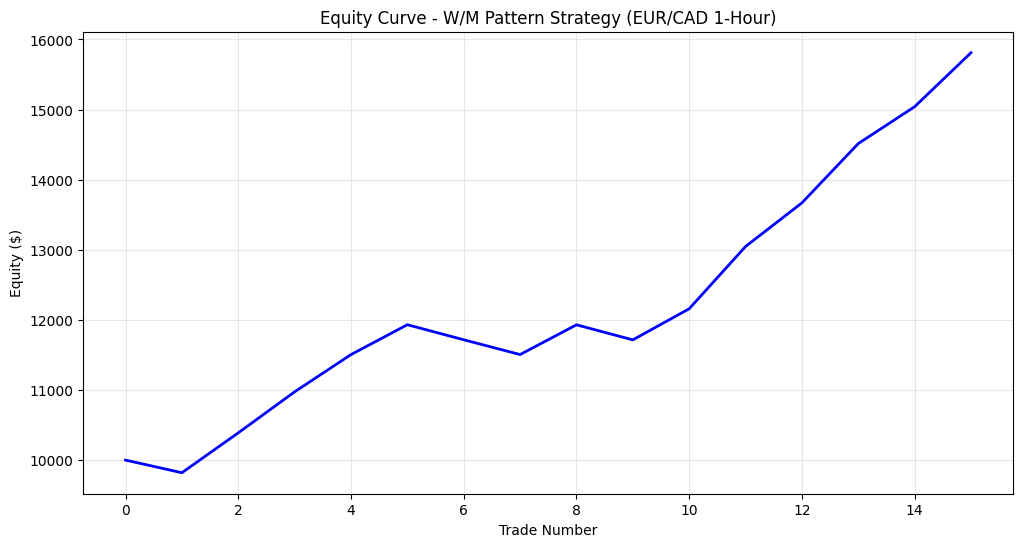

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD 1-HOUR DATA FOR EUR/CAD
# ======================
print("\U0001F4C5 Downloading EUR/CAD 1-hour data...")
symbol = "EURCAD=X"
data = yf.download(symbol, interval="1h", period="90d")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (Optimized for 1h timeframe)
# ======================
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=3)

# ======================
# 4. PATTERN DETECTION (Optimized for 1h EUR/CAD)
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP (Optimized for 1h)
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, data, initial_capital=10000, risk_percent=1.8):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
        
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        
        if risk_per_unit == 0:
            return 0
        
        position_size = risk_amount / risk_per_unit
        return position_size
    
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        entry_idx = self.data[self.data['timestamp'] == trade_setup['timestamp']].index[0]
        
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
            
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(self.data)):
            current_candle = self.data.iloc[i]
            
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(self.data):
            final_candle = self.data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(25, len(data) - 2):
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0005
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0005
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. BACKTEST EXECUTION
# ======================
if trades:
    print(f"\U0001F4CA Backtesting {len(trades)} trades...")
    
    # Initialize backtester
    backtester = Backtester(data, initial_capital=10000, risk_percent=1.8)
    
    # Execute all trades
    for trade in trades:
        backtester.execute_trade(trade)
    
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Print results
        print("\n" + "="*50)
        print("📊 BACKTESTING RESULTS - EUR/CAD 1-HOUR TIMEFRAME")
        print("="*50)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        
        # Save detailed results
        trade_results.to_csv("backtest_eurcad_1h_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'backtest_eurcad_1h_detailed_results.csv'")
        
        # Show last 5 trades
        print("\n📋 Last 5 Trades:")
        print(trade_results[['timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail().to_string(index=False))
        
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Optional)
# ======================
try:
    import matplotlib.pyplot as plt
    
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - W/M Pattern Strategy (EUR/CAD 1-Hour)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('equity_curve_eurcad_1h.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'equity_curve_eurcad_1h.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

📅 Downloading EUR/JPY 1-hour data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 2100 candles for W/M setups...
📊 Backtesting 28 trades...

📊 BACKTESTING RESULTS - EUR/JPY 1-HOUR TIMEFRAME
Initial Capital: $10,000.00
Final Capital: $11,977.42
Total Return: $1,977.43 (19.77%)
Total Trades: 28
Win Rate: 39.3%
Winning Trades: 11
Losing Trades: 17
Average Win: $459.94
Average Loss: $-181.29
Profit Factor: 1.64
Max Drawdown: -16.63%

✅ Detailed results saved to 'backtest_eurjpy_1h_detailed_results.csv'

📋 Last 5 Trades:
                    timestamp direction     entry        sl      tp     pnl  rr_ratio exit_reason
1970-01-01 00:00:00.000001645      bull 168.33400 168.08850 168.849  441.12      2.10          TP
1970-01-01 00:00:00.000001751      bull 168.96400 168.59150 169.860  524.90      2.41          TP
1970-01-01 00:00:00.000001972      bear 172.28300 172.43850 171.722 -227.67      3.61          SL
1970-01-01 00:00:00.000002077      bear 172.43600 172.62851 172.002 -223.57      2.25          SL
1970-01-01 00:00:00.000002085      bull 172.37199 172.01950

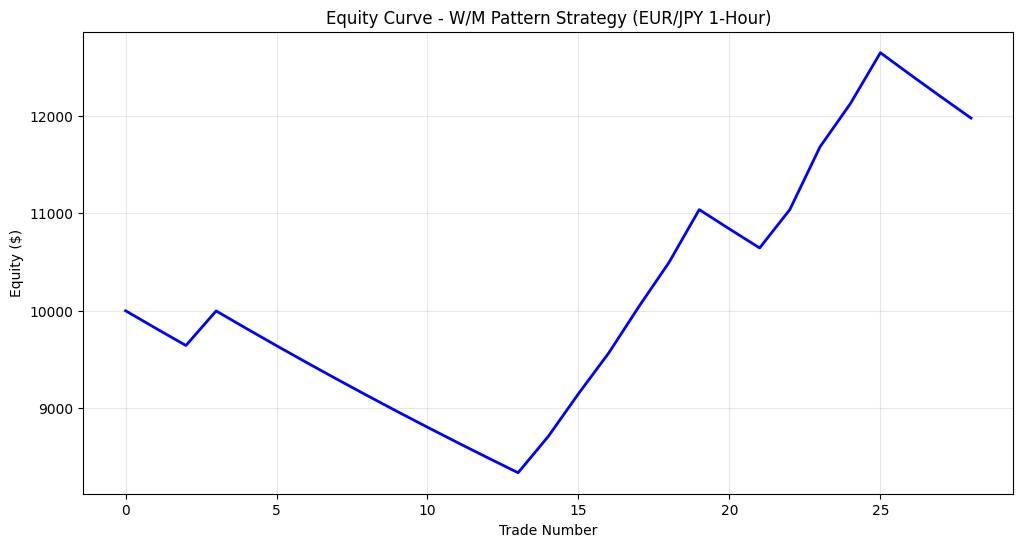

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD 1-HOUR DATA FOR EUR/JPY
# ======================
print("\U0001F4C5 Downloading EUR/JPY 1-hour data...")
symbol = "EURJPY=X"
data = yf.download(symbol, interval="1h", period="90d")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (Optimized for 1h timeframe)
# ======================
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=3)

# ======================
# 4. PATTERN DETECTION (Optimized for 1h EUR/JPY)
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP (Optimized for 1h)
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, data, initial_capital=10000, risk_percent=1.8):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
        
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        
        if risk_per_unit == 0:
            return 0
        
        position_size = risk_amount / risk_per_unit
        return position_size
    
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        entry_idx = self.data[self.data['timestamp'] == trade_setup['timestamp']].index[0]
        
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
            
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(self.data)):
            current_candle = self.data.iloc[i]
            
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(self.data):
            final_candle = self.data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(25, len(data) - 2):
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0005
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0005
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. BACKTEST EXECUTION
# ======================
if trades:
    print(f"\U0001F4CA Backtesting {len(trades)} trades...")
    
    # Initialize backtester
    backtester = Backtester(data, initial_capital=10000, risk_percent=1.8)
    
    # Execute all trades
    for trade in trades:
        backtester.execute_trade(trade)
    
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Print results
        print("\n" + "="*50)
        print("📊 BACKTESTING RESULTS - EUR/JPY 1-HOUR TIMEFRAME")
        print("="*50)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        
        # Save detailed results
        trade_results.to_csv("backtest_eurjpy_1h_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'backtest_eurjpy_1h_detailed_results.csv'")
        
        # Show last 5 trades
        print("\n📋 Last 5 Trades:")
        print(trade_results[['timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail().to_string(index=False))
        
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Optional)
# ======================
try:
    import matplotlib.pyplot as plt
    
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - W/M Pattern Strategy (EUR/JPY 1-Hour)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('equity_curve_eurjpy_1h.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'equity_curve_eurjpy_1h.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

📅 Downloading NZD/CAD 1-hour data...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 2102 candles for W/M setups...
📊 Backtesting 5 trades...

📊 BACKTESTING RESULTS - NZD/CAD 1-HOUR TIMEFRAME
Initial Capital: $10,000.00
Final Capital: $10,274.93
Total Return: $274.92 (2.75%)
Total Trades: 5
Win Rate: 40.0%
Winning Trades: 2
Losing Trades: 3
Average Win: $402.63
Average Loss: $-176.78
Profit Factor: 1.52
Max Drawdown: -5.30%

✅ Detailed results saved to 'backtest_nzdcad_1h_detailed_results.csv'

📋 Last 5 Trades:
                    timestamp direction   entry      sl      tp     pnl  rr_ratio exit_reason
1970-01-01 00:00:00.000000500      bear 0.82541 0.82762 0.81909 -180.00      2.86          SL
1970-01-01 00:00:00.000000501      bear 0.82625 0.82762 0.81909 -176.76      5.23          SL
1970-01-01 00:00:00.000000591      bear 0.82669 0.82870 0.82165 -173.58      2.51          SL
1970-01-01 00:00:00.000001136      bear 0.82444 0.82625 0.82055  366.33      2.15          TP
1970-01-01 00:00:00.000001453      bear 0.82451 0.82595 0.82094  438.93      2.48      

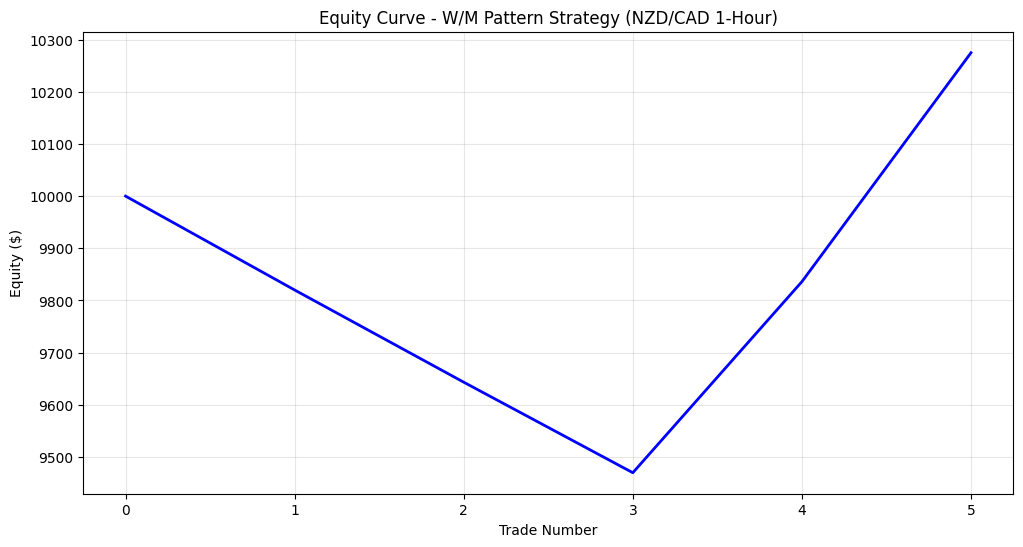

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD 1-HOUR DATA FOR NZD/CAD
# ======================
print("\U0001F4C5 Downloading NZD/CAD 1-hour data...")
symbol = "NZDCAD=X"
data = yf.download(symbol, interval="1h", period="90d")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (Optimized for 1h timeframe)
# ======================
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=3)

# ======================
# 4. PATTERN DETECTION (Optimized for 1h NZD/CAD)
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP (Optimized for 1h)
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, data, initial_capital=10000, risk_percent=1.8):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
        
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        
        if risk_per_unit == 0:
            return 0
        
        position_size = risk_amount / risk_per_unit
        return position_size
    
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        entry_idx = self.data[self.data['timestamp'] == trade_setup['timestamp']].index[0]
        
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
            
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(self.data)):
            current_candle = self.data.iloc[i]
            
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(self.data):
            final_candle = self.data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(25, len(data) - 2):
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0005
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0005
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. BACKTEST EXECUTION
# ======================
if trades:
    print(f"\U0001F4CA Backtesting {len(trades)} trades...")
    
    # Initialize backtester
    backtester = Backtester(data, initial_capital=10000, risk_percent=1.8)
    
    # Execute all trades
    for trade in trades:
        backtester.execute_trade(trade)
    
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Print results
        print("\n" + "="*50)
        print("📊 BACKTESTING RESULTS - NZD/CAD 1-HOUR TIMEFRAME")
        print("="*50)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        
        # Save detailed results
        trade_results.to_csv("backtest_nzdcad_1h_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'backtest_nzdcad_1h_detailed_results.csv'")
        
        # Show last 5 trades
        print("\n📋 Last 5 Trades:")
        print(trade_results[['timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail().to_string(index=False))
        
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Optional)
# ======================
try:
    import matplotlib.pyplot as plt
    
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - W/M Pattern Strategy (NZD/CAD 1-Hour)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('equity_curve_nzdcad_1h.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'equity_curve_nzdcad_1h.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

📅 Downloading NZD/CAD 1-hour data for Q3-Q4 2024...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 3103 candles for W/M setups...
📊 Backtesting 20 trades...

📊 BACKTESTING RESULTS - NZD/CAD 1-HOUR TIMEFRAME (Q3-Q4 2024)
Initial Capital: $10,000.00
Final Capital: $8,854.16
Total Return: $-1,145.85 (-11.46%)
Total Trades: 20
Win Rate: 20.0%
Winning Trades: 4
Losing Trades: 16
Average Win: $449.44
Average Loss: $-183.98
Profit Factor: 0.61
Max Drawdown: -11.46%

✅ Detailed results saved to 'backtest_nzdcad_1h_q3q4_2024_detailed_results.csv'

📋 Last 5 Trades:
                    timestamp direction   entry      sl      tp     pnl  rr_ratio exit_reason
1970-01-01 00:00:00.000001843      bull 0.83681 0.83412 0.84327 -174.53      2.40          SL
1970-01-01 00:00:00.000001844      bull 0.83709 0.83412 0.84327 -171.39      2.08          SL
1970-01-01 00:00:00.000001845      bull 0.83687 0.83412 0.84327 -168.30      2.33          SL
1970-01-01 00:00:00.000001847      bull 0.83595 0.83412 0.84209 -165.27      3.36          SL
1970-01-01 00:00:00.000002311      bull 0.82703 0.82498 

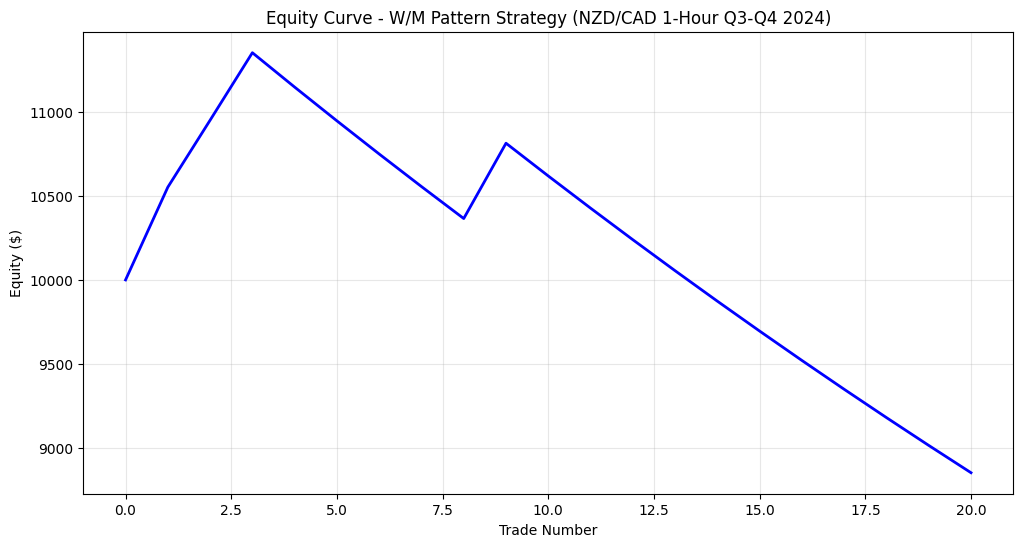

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD 1-HOUR DATA FOR NZD/CAD (LAST TWO QUARTERS OF 2024)
# ======================
print("\U0001F4C5 Downloading NZD/CAD 1-hour data for Q3-Q4 2024...")
symbol = "NZDCAD=X"

# Download data from July 1, 2024 to December 31, 2024 (Q3 and Q4)
data = yf.download(symbol, interval="1h", start="2024-07-01", end="2024-12-31")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (Optimized for 1h timeframe)
# ======================
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=3)

# ======================
# 4. PATTERN DETECTION (Optimized for 1h NZD/CAD)
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP (Optimized for 1h)
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, data, initial_capital=10000, risk_percent=1.8):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
        
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        
        if risk_per_unit == 0:
            return 0
        
        position_size = risk_amount / risk_per_unit
        return position_size
    
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        entry_idx = self.data[self.data['timestamp'] == trade_setup['timestamp']].index[0]
        
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
            
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(self.data)):
            current_candle = self.data.iloc[i]
            
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(self.data):
            final_candle = self.data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(25, len(data) - 2):
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0005
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0005
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. BACKTEST EXECUTION
# ======================
if trades:
    print(f"\U0001F4CA Backtesting {len(trades)} trades...")
    
    # Initialize backtester
    backtester = Backtester(data, initial_capital=10000, risk_percent=1.8)
    
    # Execute all trades
    for trade in trades:
        backtester.execute_trade(trade)
    
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Print results
        print("\n" + "="*50)
        print("📊 BACKTESTING RESULTS - NZD/CAD 1-HOUR TIMEFRAME (Q3-Q4 2024)")
        print("="*50)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        
        # Save detailed results
        trade_results.to_csv("backtest_nzdcad_1h_q3q4_2024_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'backtest_nzdcad_1h_q3q4_2024_detailed_results.csv'")
        
        # Show last 5 trades
        print("\n📋 Last 5 Trades:")
        print(trade_results[['timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail().to_string(index=False))
        
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Optional)
# ======================
try:
    import matplotlib.pyplot as plt
    
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - W/M Pattern Strategy (NZD/CAD 1-Hour Q3-Q4 2024)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('equity_curve_nzdcad_1h_q3q4_2024.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'equity_curve_nzdcad_1h_q3q4_2024.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

📅 Downloading EUR/CAD 1-hour data for Q3-Q4 2024...


[*********************100%***********************]  1 of 1 completed


🔍 Scanning 3097 candles for W/M setups...
📊 Backtesting 17 trades...

📊 BACKTESTING RESULTS - EUR/CAD 1-HOUR TIMEFRAME (Q3-Q4 2024)
Initial Capital: $10,000.00
Final Capital: $12,518.06
Total Return: $2,518.05 (25.18%)
Total Trades: 17
Win Rate: 41.2%
Winning Trades: 7
Losing Trades: 10
Average Win: $634.83
Average Loss: $-192.58
Profit Factor: 2.31
Max Drawdown: -5.30%

✅ Detailed results saved to 'backtest_eurcad_1h_q3q4_2024_detailed_results.csv'

📋 Last 5 Trades:
                    timestamp direction   entry      sl      tp     pnl  rr_ratio exit_reason
1970-01-01 00:00:00.000002291      bull 1.48404 1.48161 1.49163 -201.08      3.12          SL
1970-01-01 00:00:00.000002292      bull 1.48399 1.48161 1.49163 -197.46      3.21          SL
1970-01-01 00:00:00.000002430      bull 1.47919 1.47710 1.48531 -193.91      2.93          SL
1970-01-01 00:00:00.000002815      bull 1.48648 1.48502 1.49443 1036.86      5.45          TP
1970-01-01 00:00:00.000002817      bull 1.48679 1.48502 1.

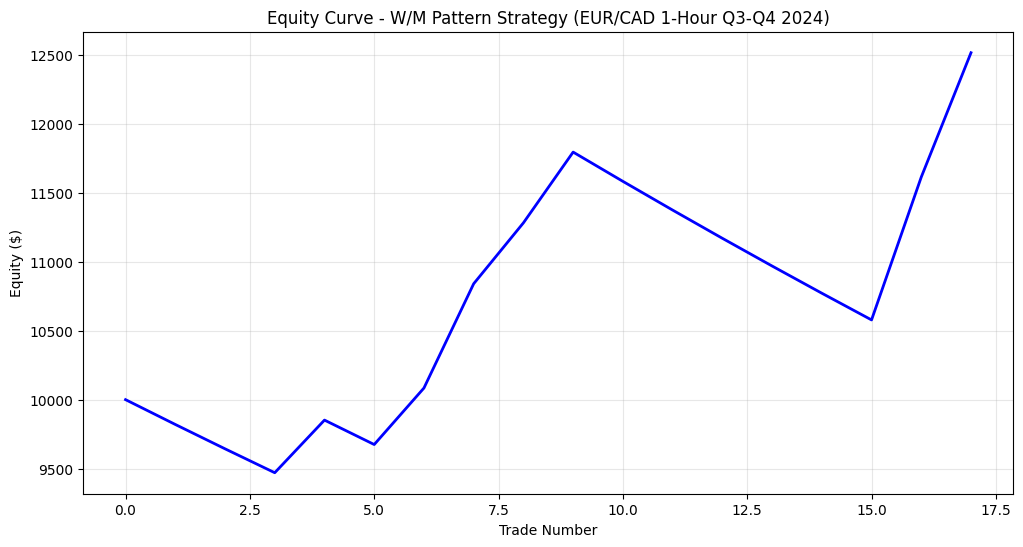

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. DOWNLOAD 1-HOUR DATA FOR EUR/CAD (LAST TWO QUARTERS OF 2024)
# ======================
print("\U0001F4C5 Downloading EUR/CAD 1-hour data for Q3-Q4 2024...")
symbol = "EURCAD=X"

# Download data from July 1, 2024 to December 31, 2024 (Q3 and Q4)
data = yf.download(symbol, interval="1h", start="2024-07-01", end="2024-12-31")

if data.empty:
    print("❌ No data returned. Check symbol or internet connection.")
    exit()

# Clean columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close']]
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)

# ======================
# 2. CALCULATE RSI
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

# ======================
# 3. FIND SWINGS (Optimized for 1h timeframe)
# ======================
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

min_idx_list, max_idx_list = find_swings(data['Low'], order=3)

# ======================
# 4. PATTERN DETECTION (Optimized for 1h EUR/CAD)
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP (Optimized for 1h)
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, data, initial_capital=10000, risk_percent=1.8):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
        
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        
        if risk_per_unit == 0:
            return 0
        
        position_size = risk_amount / risk_per_unit
        return position_size
    
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        entry_idx = self.data[self.data['timestamp'] == trade_setup['timestamp']].index[0]
        
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
            
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(self.data)):
            current_candle = self.data.iloc[i]
            
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(self.data):
            final_candle = self.data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC
# ======================
trades = []

print(f"\U0001F50D Scanning {len(data)} candles for W/M setups...")

for i in range(25, len(data) - 2):
    # --- W PATTERN ---
    is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
    if is_w and data['High'].iloc[i] > neckline_w:
        ob = find_bullish_ob(data, troughs[1], i)
        if ob is not None and data['Close'].iloc[i] > ob['High']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['Low'] - 0.0005
            tp = find_prior_swing_high(data, i)
            rr = (tp - entry) / (entry - sl) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bull',
                    'setup': 'W_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

    # --- M PATTERN ---
    is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
    if is_m and data['Low'].iloc[i] < neckline_m:
        ob = find_bearish_ob(data, peaks[1], i)
        if ob is not None and data['Close'].iloc[i] < ob['Low']:
            entry_idx = i + 1
            if entry_idx >= len(data): continue
            entry = data['Open'].iloc[entry_idx]
            sl = ob['High'] + 0.0005
            tp = find_prior_swing_low(data, i)
            rr = (entry - tp) / (sl - entry) if tp is not None else 0
            if tp is not None and rr >= 2:
                trades.append({
                    'timestamp': data['timestamp'].iloc[entry_idx],
                    'entry': round(entry, 5),
                    'sl': round(sl, 5),
                    'tp': round(tp, 5),
                    'direction': 'bear',
                    'setup': 'M_pattern',
                    'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                })

# ======================
# 9. BACKTEST EXECUTION
# ======================
if trades:
    print(f"\U0001F4CA Backtesting {len(trades)} trades...")
    
    # Initialize backtester
    backtester = Backtester(data, initial_capital=10000, risk_percent=1.8)
    
    # Execute all trades
    for trade in trades:
        backtester.execute_trade(trade)
    
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Print results
        print("\n" + "="*50)
        print("📊 BACKTESTING RESULTS - EUR/CAD 1-HOUR TIMEFRAME (Q3-Q4 2024)")
        print("="*50)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        
        # Save detailed results
        trade_results.to_csv("backtest_eurcad_1h_q3q4_2024_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'backtest_eurcad_1h_q3q4_2024_detailed_results.csv'")
        
        # Show last 5 trades
        print("\n📋 Last 5 Trades:")
        print(trade_results[['timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail().to_string(index=False))
        
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Optional)
# ======================
try:
    import matplotlib.pyplot as plt
    
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - W/M Pattern Strategy (EUR/CAD 1-Hour Q3-Q4 2024)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('equity_curve_eurcad_1h_q3q4_2024.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'equity_curve_eurcad_1h_q3q4_2024.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

📅 Downloading FX data for Q3-Q4 2024...


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

💾 Data downloaded for 11 symbols.
🔍 Scanning for W/M setups across 11 symbols...
  Scanning EURUSD=X (3091 candles)...
    Found 44 trades for EURUSD=X
  Scanning USDJPY=X (3077 candles)...
    Found 46 trades for USDJPY=X
  Scanning GBPUSD=X (3092 candles)...
    Found 28 trades for GBPUSD=X
  Scanning USDCHF=X (3087 candles)...
    Found 16 trades for USDCHF=X
  Scanning AUDUSD=X (3105 candles)...
    Found 9 trades for AUDUSD=X
  Scanning USDCAD=X (3110 candles)...
    Found 27 trades for USDCAD=X
  Scanning NZDUSD=X (3104 candles)...
    Found 41 trades for NZDUSD=X
  Scanning EURJPY=X (3095 candles)...
    Found 33 trades for EURJPY=X
  Scanning GBPJPY=X (3093 candles)...
    Found 62 trades for GBPJPY=X
  Scanning EURGBP=X (3095 candles)...
    Found 26 trades for EURGBP=X
  Scanning EURCAD=X (3097 candles)...
    Found 17 trades for EURCAD=X
📊 Backtesting 349 total trades...

📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q3-Q4 2024)
Initial Capital: $10,000.00
Final Capital: $29,

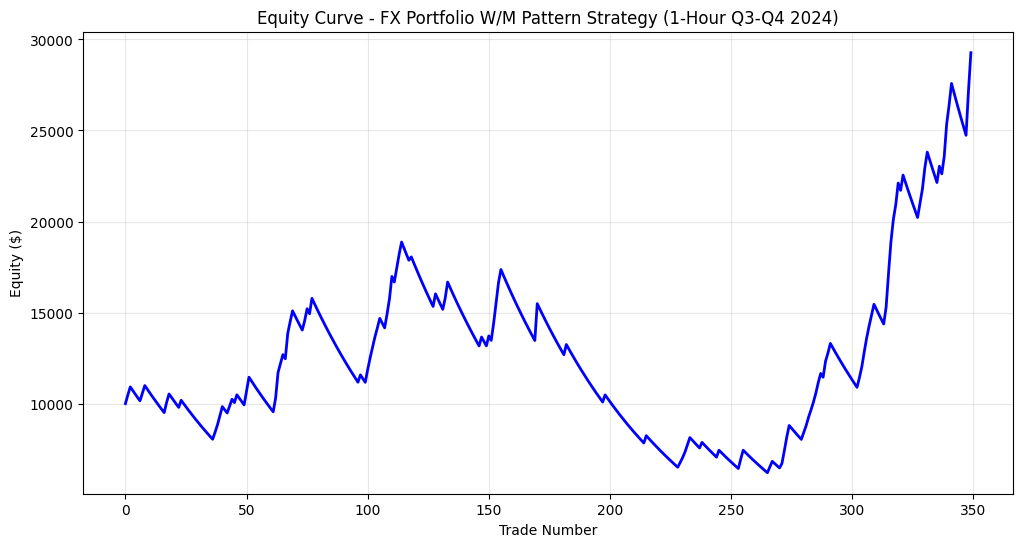

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q3-Q4 2024...")

# List of FX pairs to trade
symbols = [
    "EURUSD=X", "USDJPY=X", "GBPUSD=X", "USDCHF=X",
    "AUDUSD=X", "USDCAD=X", "NZDUSD=X", "EURJPY=X",
    "GBPJPY=X", "EURGBP=X", "EURCAD=X"
]

# Download data from July 1, 2024 to December 31, 2024 (Q3 and Q4)
start_date = "2024-07-01"
end_date = "2024-12-31"

# Dictionary to store data for each symbol
all_data = {}

# ======================
# 2. DOWNLOAD AND PREPARE DATA
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 1-hour data...")
    data = yf.download(symbol, interval="1h", start=start_date, end=end_date)
    
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    
    # Store the cleaned data
    all_data[symbol] = data

if not all_data:
    print("❌ No data available for any symbol. Exiting.")
    exit()

print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols.")

# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data

# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []

    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size

    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
            
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
                
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS
# ======================
all_trades = []

print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols...")

for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)

# ======================
# 9. BACKTEST EXECUTION
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades...")
    
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)
    
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q3-Q4 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        
        # Save detailed results
        trade_results.to_csv("portfolio_backtest_fx_1h_q3q4_2024_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_1h_q3q4_2024_detailed_results.csv'")
        
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (1-Hour Q3-Q4 2024)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('portfolio_equity_curve_fx_1h_q3q4_2024.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_1h_q3q4_2024.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")


📅 Downloading FX data for Q3-Q4 2024...


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

💾 Data downloaded for 6 symbols.
🔍 Scanning for W/M setups across 6 symbols...
  Scanning EURGBP=X (3095 candles)...
    Found 26 trades for EURGBP=X
  Scanning GBPUSD=X (3092 candles)...
    Found 28 trades for GBPUSD=X
  Scanning EURCAD=X (3097 candles)...
    Found 17 trades for EURCAD=X
  Scanning GBPJPY=X (3093 candles)...
    Found 62 trades for GBPJPY=X
  Scanning USDJPY=X (3077 candles)...
    Found 46 trades for USDJPY=X
  Scanning USDCAD=X (3110 candles)...
    Found 27 trades for USDCAD=X
📊 Backtesting 206 total trades...

📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q3-Q4 2024)
Initial Capital: $10,000.00
Final Capital: $81,424.65
Total Return: $71,424.73 (714.25%)
Total Trades: 206
Win Rate: 38.3%
Winning Trades: 79
Losing Trades: 127
Average Win: $2,315.86
Average Loss: $-878.18
Profit Factor: 1.64
Max Drawdown: 0.00%

----------------------------------------
PER-SYMBOL PERFORMANCE:
----------------------------------------
          trades       pnl  win_rate
symbol      

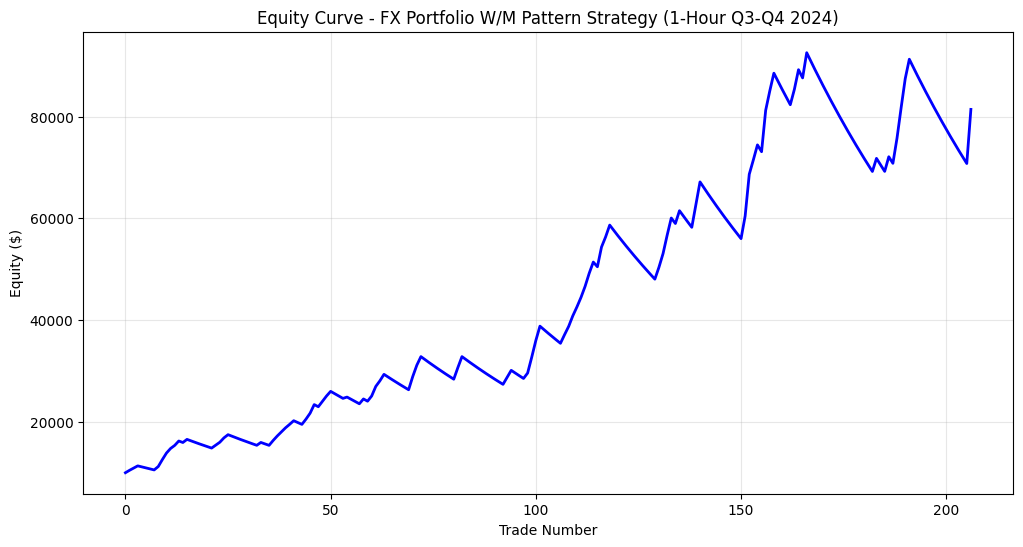

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")
# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q3-Q4 2024...")
# List of FX pairs to trade (Updated list)
symbols = [
    "EURGBP=X", "GBPUSD=X", "EURCAD=X", "GBPJPY=X", "USDJPY=X", "USDCAD=X"
]
# Download data from July 1, 2024 to December 31, 2024 (Q3 and Q4)
start_date = "2024-07-01"
end_date = "2024-12-31"
# Dictionary to store data for each symbol
all_data = {}
# ======================
# 2. DOWNLOAD AND PREPARE DATA
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 1-hour data...")
    data = yf.download(symbol, interval="1h", start=start_date, end=end_date)
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    # Store the cleaned data
    all_data[symbol] = data
if not all_data:
    print("❌ No data available for any symbol. Exiting.")
    exit()
print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols.")
# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])
# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data
# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None
def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None
# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob
def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob
# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None
def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None
# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result
# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS
# ======================
all_trades = []
print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols...")
for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)
# ======================
# 9. BACKTEST EXECUTION
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades...")
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        max_drawdown = ((min_equity - backtester.initial_capital) / backtester.initial_capital) * 100
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q3-Q4 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        # Save detailed results
        trade_results.to_csv("portfolio_backtest_fx_1h_q3q4_2024_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_1h_q3q4_2024_detailed_results.csv'")
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")
# ======================
# 11. EQUITY CURVE VISUALIZATION
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (1-Hour Q3-Q4 2024)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('portfolio_equity_curve_fx_1h_q3q4_2024.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_1h_q3q4_2024.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")


📅 Downloading FX data for Q3-Q4 2024 (H4 timeframe)...


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


💾 Data downloaded for 6 symbols (H4).
🔍 Scanning for W/M setups across 6 symbols (H4)...
  Scanning EURGBP=X (772 candles)...
    Found 6 trades for EURGBP=X
  Scanning GBPUSD=X (771 candles)...
    Found 6 trades for GBPUSD=X
  Scanning EURCAD=X (772 candles)...
    Found 10 trades for EURCAD=X
  Scanning GBPJPY=X (772 candles)...
    Found 7 trades for GBPJPY=X
  Scanning USDJPY=X (771 candles)...
    Found 13 trades for USDJPY=X
  Scanning USDCAD=X (773 candles)...
    Found 9 trades for USDCAD=X
📊 Backtesting 51 total trades (H4)...

📊 PORTFOLIO BACKTESTING RESULTS - FX 4-HOUR (Q3-Q4 2024)
Initial Capital: $10,000.00
Final Capital: $17,155.23
Total Return: $7,155.23 (71.55%)
Total Trades: 51
Win Rate: 37.3%
Winning Trades: 19
Losing Trades: 32
Average Win: $829.77
Average Loss: $-269.08
Profit Factor: 1.83
Max Drawdown: 20.67%

----------------------------------------
PER-SYMBOL PERFORMANCE:
----------------------------------------
          trades      pnl  win_rate
symbol        

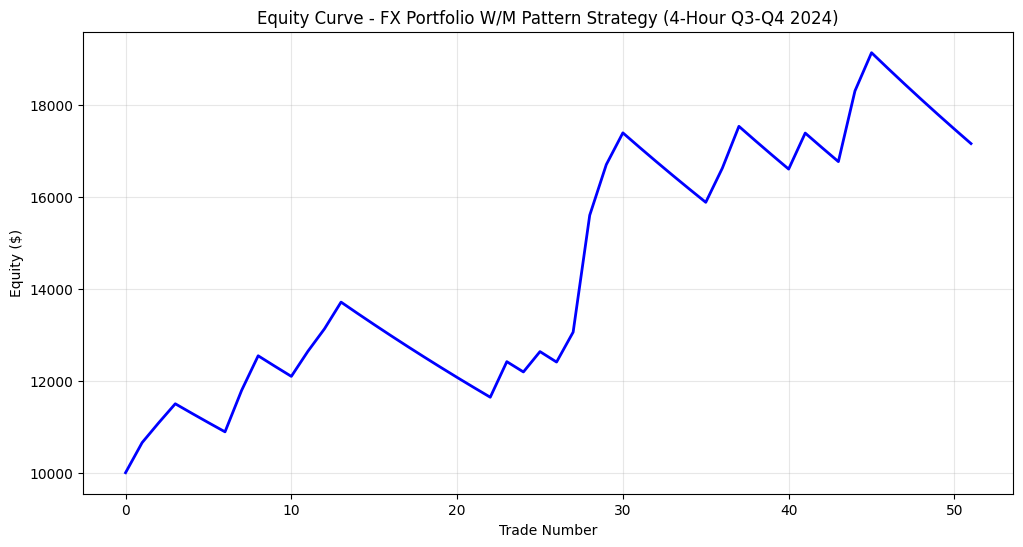

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")
# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q3-Q4 2024 (H4 timeframe)...")
# List of FX pairs to trade (Updated list as per your request)
symbols = [
    "EURGBP=X", "GBPUSD=X", "EURCAD=X", "GBPJPY=X", "USDJPY=X", "USDCAD=X"
]
# Download data from July 1, 2024 to December 31, 2024 (Q3 and Q4)
start_date = "2024-07-01"
end_date = "2024-12-31"
# Dictionary to store data for each symbol
all_data = {}
# ======================
# 2. DOWNLOAD AND PREPARE DATA (H4)
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 4-hour data...")
    # Change interval to 4h
    data = yf.download(symbol, interval="4h", start=start_date, end=end_date)
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    # Store the cleaned data
    all_data[symbol] = data
if not all_data:
    print("❌ No data available for any symbol. Exiting.")
    exit()
print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols (H4).")
# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])
# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data
# ======================
# 4. PATTERN DETECTION (Parameters might need adjustment for H4)
# ======================
# Consider adjusting 'window' or price/RSI thresholds if patterns are too sparse/rich
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None
def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None
# ======================
# 5. ORDER BLOCK (OB) DETECTION (Logic stays the same)
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob
def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob
# ======================
# 6. SWING HIGH/LOW FOR TP (Lookback might need adjustment for H4)
# ======================
# Increased lookback slightly as H4 candles represent longer periods
def find_prior_swing_high(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None
def find_prior_swing_low(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None
# ======================
# 7. BACKTESTING ENGINE (Logic stays the same)
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result
# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS (Logic stays the same)
# ======================
all_trades = []
print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols (H4)...")
for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)
# ======================
# 9. BACKTEST EXECUTION (Logic stays the same)
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades (H4)...")
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)
    # ======================
    # 10. PERFORMANCE METRICS (Logic stays the same)
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        # Fix for Max Drawdown calculation
        # Track peak equity for drawdown calculation
        peak_equity = backtester.initial_capital
        max_dd_value = 0
        for equity in backtester.equity_curve:
             if equity > peak_equity:
                 peak_equity = equity
             dd = peak_equity - equity
             if dd > max_dd_value:
                 max_dd_value = dd
        max_drawdown = (max_dd_value / backtester.initial_capital) * 100 if backtester.initial_capital > 0 else 0

        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 4-HOUR (Q3-Q4 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        # Save detailed results
        trade_results.to_csv("portfolio_backtest_fx_h4_q3q4_2024_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_h4_q3q4_2024_detailed_results.csv'")
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")
# ======================
# 11. EQUITY CURVE VISUALIZATION (Filename updated)
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (4-Hour Q3-Q4 2024)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        # Updated filename for H4
        plt.savefig('portfolio_equity_curve_fx_h4_q3q4_2024.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_h4_q3q4_2024.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")


📅 Downloading FX data for Q3-Q4 2024 (H4 timeframe)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

💾 Data downloaded for 11 symbols (H4).
🔍 Scanning for W/M setups across 11 symbols (H4)...
  Scanning EURUSD=X (771 candles)...
    Found 26 trades for EURUSD=X
  Scanning USDJPY=X (771 candles)...
    Found 13 trades for USDJPY=X
  Scanning GBPUSD=X (771 candles)...
    Found 6 trades for GBPUSD=X
  Scanning USDCHF=X (771 candles)...
    Found 16 trades for USDCHF=X
  Scanning AUDUSD=X (773 candles)...
    Found 10 trades for AUDUSD=X
  Scanning USDCAD=X (773 candles)...
    Found 9 trades for USDCAD=X
  Scanning NZDUSD=X (773 candles)...
    Found 26 trades for NZDUSD=X
  Scanning EURJPY=X (772 candles)...
    Found 3 trades for EURJPY=X
  Scanning GBPJPY=X (772 candles)...
    Found 7 trades for GBPJPY=X
  Scanning EURGBP=X (772 candles)...
    Found 6 trades for EURGBP=X
  Scanning EURCAD=X (772 candles)...
    Found 10 trades for EURCAD=X
📊 Backtesting 132 total trades (H4)...

📊 PORTFOLIO BACKTESTING RESULTS - FX 4-HOUR (Q3-Q4 2024)
Initial Capital: $10,000.00
Final Capital: $14,

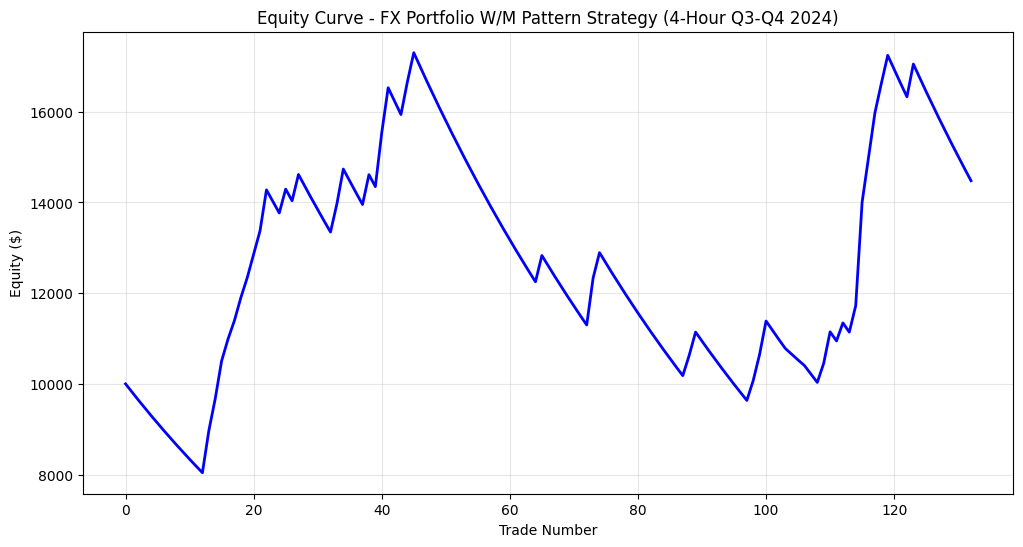

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q3-Q4 2024 (H4 timeframe)...")

# List of FX pairs to trade (Updated list as per your request)
# Note: Yahoo Finance uses specific ticker formats, often with '=X' suffix for FX
symbols = [
    "EURUSD=X", "USDJPY=X", "GBPUSD=X", "USDCHF=X",
    "AUDUSD=X", "USDCAD=X", "NZDUSD=X", "EURJPY=X",
    "GBPJPY=X", "EURGBP=X", "EURCAD=X"
]

# Download data from July 1, 2024 to December 31, 2024 (Q3 and Q4)
start_date = "2024-07-01"
end_date = "2024-12-31"

# Dictionary to store data for each symbol
all_data = {}

# ======================
# 2. DOWNLOAD AND PREPARE DATA (H4)
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 4-hour data...")
    # Change interval to 4h
    data = yf.download(symbol, interval="4h", start=start_date, end=end_date)
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    # Store the cleaned data
    all_data[symbol] = data

if not all_data:
    print("❌ No data available for any symbol. Exiting.")
    exit()

print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols (H4).")

# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data

# ======================
# 4. PATTERN DETECTION (Parameters might need adjustment for H4)
# ======================
# Consider adjusting 'window' or price/RSI thresholds if patterns are too sparse/rich
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION (Logic stays the same)
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP (Lookback might need adjustment for H4)
# ======================
# Increased lookback slightly as H4 candles represent longer periods
def find_prior_swing_high(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE (Logic stays the same)
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []

    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size

    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS (Logic stays the same)
# ======================
all_trades = []
print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols (H4)...")

for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)

# ======================
# 9. BACKTEST EXECUTION (Logic stays the same)
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades (H4)...")
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)

    # ======================
    # 10. PERFORMANCE METRICS (Logic stays the same)
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        # Fix for Max Drawdown calculation
        # Track peak equity for drawdown calculation
        peak_equity = backtester.initial_capital
        max_dd_value = 0
        for equity in backtester.equity_curve:
             if equity > peak_equity:
                 peak_equity = equity
             dd = peak_equity - equity
             if dd > max_dd_value:
                 max_dd_value = dd
        max_drawdown = (max_dd_value / backtester.initial_capital) * 100 if backtester.initial_capital > 0 else 0
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 4-HOUR (Q3-Q4 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        # Save detailed results
        trade_results.to_csv("portfolio_backtest_fx_h4_q3q4_2024_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_h4_q3q4_2024_detailed_results.csv'")
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Filename updated)
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (4-Hour Q3-Q4 2024)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        # Updated filename for H4
        plt.savefig('portfolio_equity_curve_fx_h4_q3q4_2024.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_h4_q3q4_2024.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

📅 Downloading FX data for Q1-Q2 2024...


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


💾 Data downloaded for 11 symbols.
🔍 Scanning for W/M setups across 11 symbols...
  Scanning EURUSD=X (3061 candles)...
    Found 44 trades for EURUSD=X
  Scanning USDJPY=X (3045 candles)...
    Found 27 trades for USDJPY=X
  Scanning GBPUSD=X (3061 candles)...
    Found 49 trades for GBPUSD=X
  Scanning USDCHF=X (3055 candles)...
    Found 32 trades for USDCHF=X
  Scanning AUDUSD=X (3078 candles)...
    Found 22 trades for AUDUSD=X
  Scanning USDCAD=X (3075 candles)...
    Found 31 trades for USDCAD=X
  Scanning NZDUSD=X (3079 candles)...
    Found 33 trades for NZDUSD=X
  Scanning EURJPY=X (3060 candles)...
    Found 40 trades for EURJPY=X
  Scanning GBPJPY=X (3061 candles)...
    Found 29 trades for GBPJPY=X
  Scanning EURGBP=X (3062 candles)...
    Found 5 trades for EURGBP=X
  Scanning EURCAD=X (3062 candles)...
    Found 20 trades for EURCAD=X
📊 Backtesting 332 total trades...

📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q1-Q2 2024)
Initial Capital: $10,000.00
Final Capital: $118

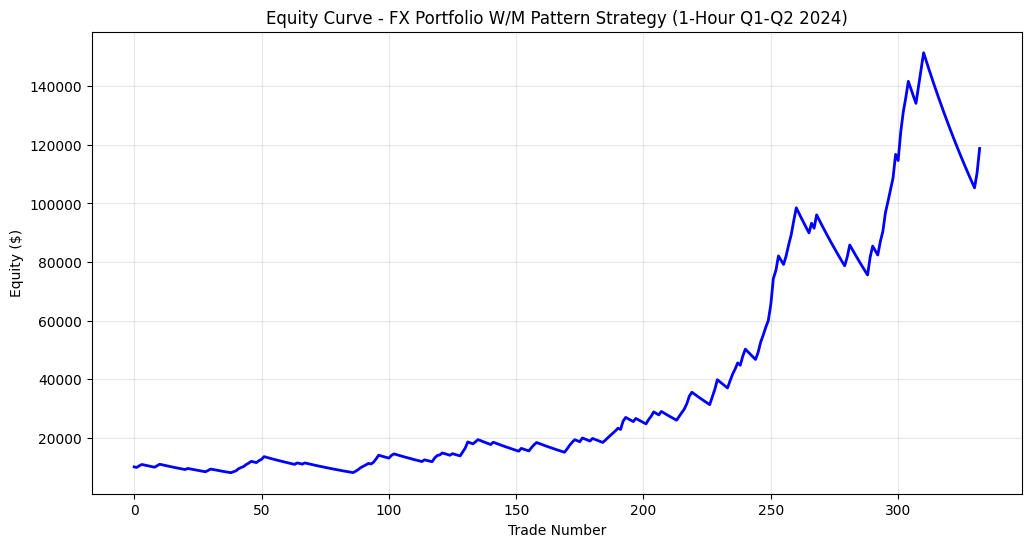

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q1-Q2 2024...")

# List of FX pairs to trade (Updated list as per your request)
# Note: Yahoo Finance uses specific ticker formats, often with '=X' suffix for FX
symbols = [
    "EURUSD=X", "USDJPY=X", "GBPUSD=X", "USDCHF=X",
    "AUDUSD=X", "USDCAD=X", "NZDUSD=X", "EURJPY=X",
    "GBPJPY=X", "EURGBP=X", "EURCAD=X"
]

# Download data from January 1, 2024 to June 30, 2024 (Q1 and Q2)
start_date = "2024-01-01"
end_date = "2024-06-30"

# Dictionary to store data for each symbol
all_data = {}

# ======================
# 2. DOWNLOAD AND PREPARE DATA
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 1-hour data...")
    data = yf.download(symbol, interval="1h", start=start_date, end=end_date)
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    # Store the cleaned data
    all_data[symbol] = data

if not all_data:
    print("❌ No data available for any symbol. Exiting.")
    exit()

print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols.")

# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data

# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []

    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size

    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS
# ======================
all_trades = []
print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols...")

for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)

# ======================
# 9. BACKTEST EXECUTION
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades...")
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)

    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        # Fix for Max Drawdown calculation
        # Track peak equity for drawdown calculation
        peak_equity = backtester.initial_capital
        max_dd_value = 0
        for equity in backtester.equity_curve:
             if equity > peak_equity:
                 peak_equity = equity
             dd = peak_equity - equity
             if dd > max_dd_value:
                 max_dd_value = dd
        max_drawdown = (max_dd_value / backtester.initial_capital) * 100 if backtester.initial_capital > 0 else 0
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q1-Q2 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        # Save detailed results
        trade_results.to_csv("portfolio_backtest_fx_1h_q1q2_2024_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_1h_q1q2_2024_detailed_results.csv'")
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (1-Hour Q1-Q2 2024)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('portfolio_equity_curve_fx_1h_q1q2_2024.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_1h_q1q2_2024.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

[*********************100%***********************]  1 of 1 completed

📅 Downloading FX data for Q3-Q4 2024 (H4 timeframe)...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


💾 Data downloaded for 20 symbols (H4).
🔍 Scanning for W/M setups across 20 symbols (H4)...
  Scanning EURUSD=X (771 candles)...
    Found 26 trades for EURUSD=X
  Scanning USDJPY=X (771 candles)...
    Found 13 trades for USDJPY=X
  Scanning GBPUSD=X (771 candles)...
    Found 6 trades for GBPUSD=X
  Scanning USDCHF=X (771 candles)...
    Found 16 trades for USDCHF=X
  Scanning AUDUSD=X (773 candles)...
    Found 10 trades for AUDUSD=X
  Scanning USDCAD=X (773 candles)...
    Found 9 trades for USDCAD=X
  Scanning NZDUSD=X (773 candles)...
    Found 26 trades for NZDUSD=X
  Scanning EURGBP=X (772 candles)...
    Found 6 trades for EURGBP=X
  Scanning EURJPY=X (772 candles)...
    Found 3 trades for EURJPY=X
  Scanning EURAUD=X (772 candles)...
    Found 17 trades for EURAUD=X
  Scanning EURCAD=X (772 candles)...
    Found 10 trades for EURCAD=X
  Scanning GBPJPY=X (772 candles)...
    Found 7 trades for GBPJPY=X
  Scanning GBPAUD=X (773 candles)...
    Found 3 trades for GBPAUD=X
  Sca

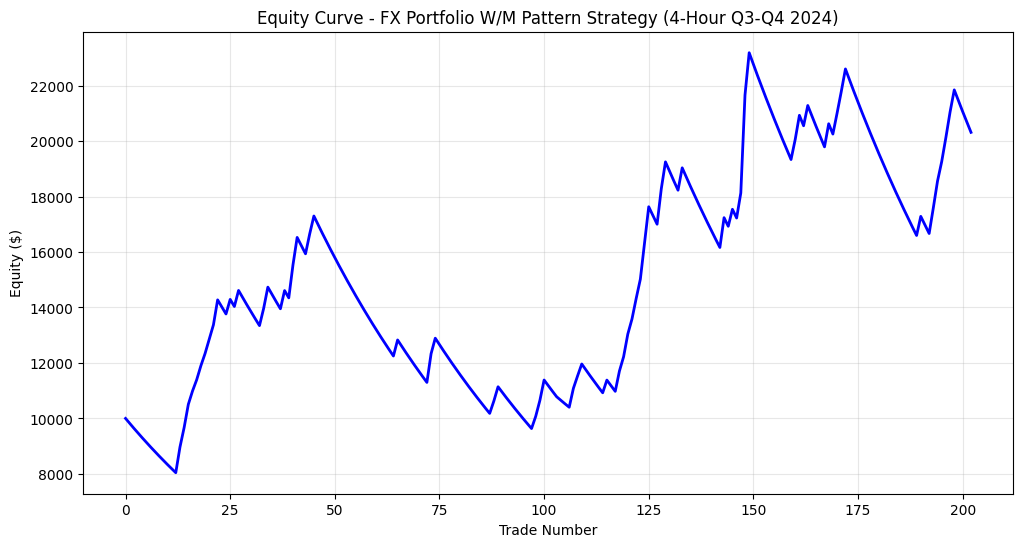

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q3-Q4 2024 (H4 timeframe)...")

# List of FX pairs to trade (Updated list as per your request)
# Note: Yahoo Finance uses specific ticker formats, often with '=X' suffix for FX
symbols = [
    "EURUSD=X", "USDJPY=X", "GBPUSD=X", "USDCHF=X",
    "AUDUSD=X", "USDCAD=X", "NZDUSD=X", "EURGBP=X",
    "EURJPY=X", "EURAUD=X", "EURCAD=X", "GBPJPY=X",
    "GBPAUD=X", "GBPCAD=X", "AUDJPY=X", "AUDNZD=X",
    "CHFJPY=X", "NZDJPY=X", "CADJPY=X", "EURNZD=X"
]

# Download data from July 1, 2024 to December 31, 2024 (Q3 and Q4)
start_date = "2024-07-01"
end_date = "2024-12-31"

# Dictionary to store data for each symbol
all_data = {}

# ======================
# 2. DOWNLOAD AND PREPARE DATA (H4)
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 4-hour data...")
    # Change interval to 4h
    data = yf.download(symbol, interval="4h", start=start_date, end=end_date)
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    # Store the cleaned data
    all_data[symbol] = data

if not all_data:
    print("❌ No data available for any symbol. Exiting.")
    exit()

print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols (H4).")

# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data

# ======================
# 4. PATTERN DETECTION (Parameters might need adjustment for H4)
# ======================
# Consider adjusting 'window' or price/RSI thresholds if patterns are too sparse/rich
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION (Logic stays the same)
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP (Lookback might need adjustment for H4)
# ======================
# Increased lookback slightly as H4 candles represent longer periods
def find_prior_swing_high(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=30):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE (Logic stays the same)
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []

    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size

    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS (Logic stays the same)
# ======================
all_trades = []
print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols (H4)...")

for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)

# ======================
# 9. BACKTEST EXECUTION (Logic stays the same)
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades (H4)...")
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)

    # ======================
    # 10. PERFORMANCE METRICS (Logic stays the same)
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        # Fix for Max Drawdown calculation
        # Track peak equity for drawdown calculation
        peak_equity = backtester.initial_capital
        max_dd_value = 0
        for equity in backtester.equity_curve:
             if equity > peak_equity:
                 peak_equity = equity
             dd = peak_equity - equity
             if dd > max_dd_value:
                 max_dd_value = dd
        max_drawdown = (max_dd_value / backtester.initial_capital) * 100 if backtester.initial_capital > 0 else 0
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 4-HOUR (Q3-Q4 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        # Save detailed results
        trade_results.to_csv("portfolio_backtest_fx_h4_q3q4_2024_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_h4_q3q4_2024_detailed_results.csv'")
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION (Filename updated)
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (4-Hour Q3-Q4 2024)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        # Updated filename for H4
        plt.savefig('portfolio_equity_curve_fx_h4_q3q4_2024.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_h4_q3q4_2024.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

[*********************100%***********************]  1 of 1 completed

📅 Downloading FX data for Q1-Q2 2024 (H1 timeframe)...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


💾 Data downloaded for 20 symbols (H1).
🔍 Scanning for W/M setups across 20 symbols (H1)...
  Scanning EURUSD=X (3061 candles)...
    Found 44 trades for EURUSD=X
  Scanning USDJPY=X (3045 candles)...
    Found 27 trades for USDJPY=X
  Scanning GBPUSD=X (3061 candles)...
    Found 49 trades for GBPUSD=X
  Scanning USDCHF=X (3055 candles)...
    Found 32 trades for USDCHF=X
  Scanning AUDUSD=X (3078 candles)...
    Found 22 trades for AUDUSD=X
  Scanning USDCAD=X (3075 candles)...
    Found 31 trades for USDCAD=X
  Scanning NZDUSD=X (3079 candles)...
    Found 33 trades for NZDUSD=X
  Scanning EURGBP=X (3062 candles)...
    Found 5 trades for EURGBP=X
  Scanning EURJPY=X (3060 candles)...
    Found 40 trades for EURJPY=X
  Scanning EURAUD=X (3062 candles)...
    Found 14 trades for EURAUD=X
  Scanning EURCAD=X (3062 candles)...
    Found 20 trades for EURCAD=X
  Scanning GBPJPY=X (3061 candles)...
    Found 29 trades for GBPJPY=X
  Scanning GBPAUD=X (3078 candles)...
    Found 13 trades 

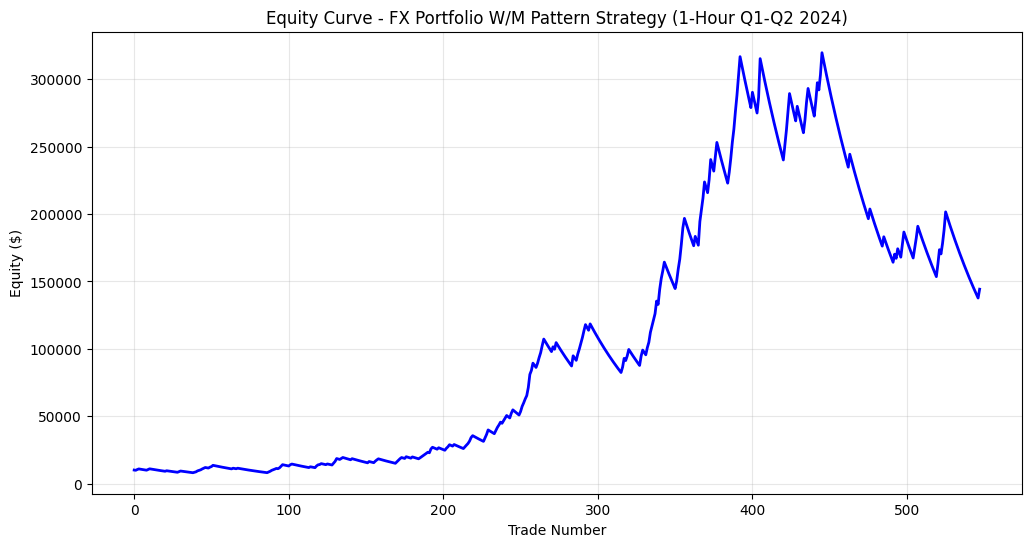

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q1-Q2 2024 (H1 timeframe)...")

# List of FX pairs to trade (Updated list as per your request)
# Note: Yahoo Finance uses specific ticker formats, often with '=X' suffix for FX
symbols = [
    "EURUSD=X", "USDJPY=X", "GBPUSD=X", "USDCHF=X",
    "AUDUSD=X", "USDCAD=X", "NZDUSD=X", "EURGBP=X",
    "EURJPY=X", "EURAUD=X", "EURCAD=X", "GBPJPY=X",
    "GBPAUD=X", "GBPCAD=X", "AUDJPY=X", "AUDNZD=X",
    "CHFJPY=X", "NZDJPY=X", "CADJPY=X", "EURNZD=X"
]

# Download data from January 1, 2024 to June 30, 2024 (Q1 and Q2)
start_date = "2024-01-01"
end_date = "2024-06-30"

# Dictionary to store data for each symbol
all_data = {}

# ======================
# 2. DOWNLOAD AND PREPARE DATA (H1)
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 1-hour data...")
    data = yf.download(symbol, interval="1h", start=start_date, end=end_date)
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    # Store the cleaned data
    all_data[symbol] = data

if not all_data:
    print("❌ No data available for any symbol. Exiting.")
    exit()

print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols (H1).")

# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])

# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data

# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None

def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None

# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob

def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob

# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None

def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None

# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []

    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size

    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result

# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS
# ======================
all_trades = []
print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols (H1)...")

for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)

# ======================
# 9. BACKTEST EXECUTION
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades (H1)...")
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)

    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        # Fix for Max Drawdown calculation
        # Track peak equity for drawdown calculation
        peak_equity = backtester.initial_capital
        max_dd_value = 0
        for equity in backtester.equity_curve:
             if equity > peak_equity:
                 peak_equity = equity
             dd = peak_equity - equity
             if dd > max_dd_value:
                 max_dd_value = dd
        max_drawdown = (max_dd_value / backtester.initial_capital) * 100 if backtester.initial_capital > 0 else 0
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q1-Q2 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        # Save detailed results
        trade_results.to_csv("portfolio_backtest_fx_h1_q1q2_2024_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_h1_q1q2_2024_detailed_results.csv'")
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")

# ======================
# 11. EQUITY CURVE VISUALIZATION
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (1-Hour Q1-Q2 2024)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('portfolio_equity_curve_fx_h1_q1q2_2024.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_h1_q1q2_2024.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")

[*********************100%***********************]  1 of 1 completed

📅 Downloading FX data for Q3-Q4 2024 (H1 timeframe)...


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


💾 Data downloaded for 20 symbols (H1).
🔍 Scanning for W/M setups across 20 symbols (H1)...
  Scanning EURUSD=X (3091 candles)...
    Found 44 trades for EURUSD=X
  Scanning USDJPY=X (3077 candles)...
    Found 46 trades for USDJPY=X
  Scanning GBPUSD=X (3092 candles)...
    Found 28 trades for GBPUSD=X
  Scanning USDCHF=X (3087 candles)...
    Found 16 trades for USDCHF=X
  Scanning AUDUSD=X (3105 candles)...
    Found 9 trades for AUDUSD=X
  Scanning USDCAD=X (3110 candles)...
    Found 27 trades for USDCAD=X
  Scanning NZDUSD=X (3104 candles)...
    Found 41 trades for NZDUSD=X
  Scanning EURGBP=X (3095 candles)...
    Found 26 trades for EURGBP=X
  Scanning EURJPY=X (3095 candles)...
    Found 33 trades for EURJPY=X
  Scanning EURAUD=X (3096 candles)...
    Found 21 trades for EURAUD=X
  Scanning EURCAD=X (3097 candles)...
    Found 17 trades for EURCAD=X
  Scanning GBPJPY=X (3093 candles)...
    Found 62 trades for GBPJPY=X
  Scanning GBPAUD=X (3102 candles)...
    Found 18 trades 

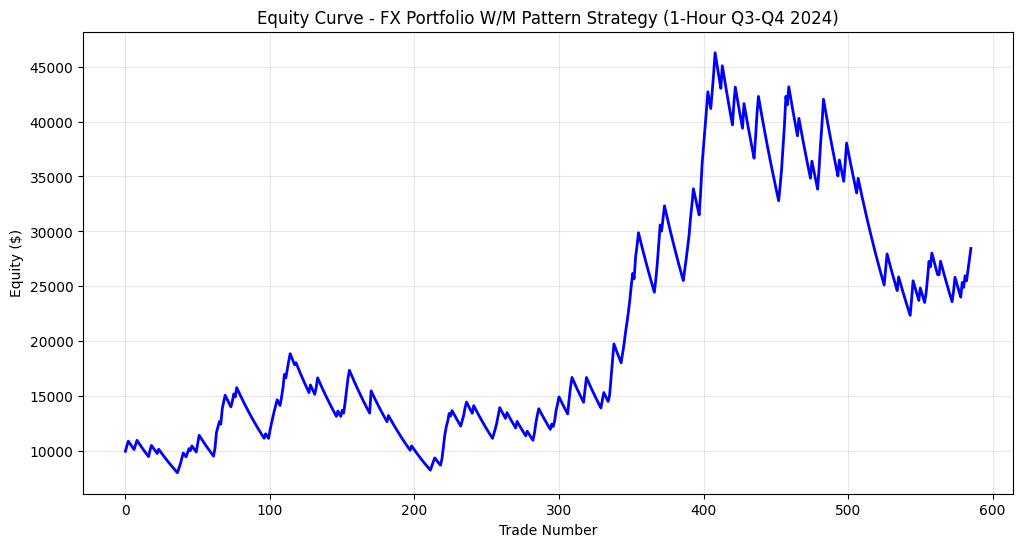

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")
# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q3-Q4 2024 (H1 timeframe)...")
# List of FX pairs to trade (Updated list as per your request)
# Note: Yahoo Finance uses specific ticker formats, often with '=X' suffix for FX
symbols = [
    "EURUSD=X", "USDJPY=X", "GBPUSD=X", "USDCHF=X",
    "AUDUSD=X", "USDCAD=X", "NZDUSD=X", "EURGBP=X",
    "EURJPY=X", "EURAUD=X", "EURCAD=X", "GBPJPY=X",
    "GBPAUD=X", "GBPCAD=X", "AUDJPY=X", "AUDNZD=X",
    "CHFJPY=X", "NZDJPY=X", "CADJPY=X", "EURNZD=X"
]
# Download data from July 1, 2024 to December 31, 2024 (Q3 and Q4)
start_date = "2024-07-01"
end_date = "2024-12-31"
# Dictionary to store data for each symbol
all_data = {}
# ======================
# 2. DOWNLOAD AND PREPARE DATA (H1)
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 1-hour data...")
    data = yf.download(symbol, interval="1h", start=start_date, end=end_date)
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    # Store the cleaned data
    all_data[symbol] = data
if not all_data:
    print("❌ No data available for any symbol. Exiting.")
    exit()
print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols (H1).")
# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])
# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data
# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None
def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None
# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob
def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob
# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None
def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None
# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result
# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS
# ======================
all_trades = []
print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols (H1)...")
for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)
# ======================
# 9. BACKTEST EXECUTION
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades (H1)...")
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        # Fix for Max Drawdown calculation
        # Track peak equity for drawdown calculation
        peak_equity = backtester.initial_capital
        max_dd_value = 0
        for equity in backtester.equity_curve:
             if equity > peak_equity:
                 peak_equity = equity
             dd = peak_equity - equity
             if dd > max_dd_value:
                 max_dd_value = dd
        max_drawdown = (max_dd_value / backtester.initial_capital) * 100 if backtester.initial_capital > 0 else 0
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q3-Q4 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        # Save detailed results
        # Updated filename for Q3-Q4 2024
        trade_results.to_csv("portfolio_backtest_fx_h1_q3q4_2024_detailed_results.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_h1_q3q4_2024_detailed_results.csv'")
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")
# ======================
# 11. EQUITY CURVE VISUALIZATION
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        # Updated plot title for Q3-Q4 2024
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (1-Hour Q3-Q4 2024)')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        # Updated filename for Q3-Q4 2024
        plt.savefig('portfolio_equity_curve_fx_h1_q3q4_2024.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_h1_q3q4_2024.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")


📅 Downloading FX data for Q3-Q4 2024 (H1 timeframe)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


💾 Data downloaded for 10 symbols (H1).
🔍 Scanning for W/M setups across 10 symbols (H1)...
  Scanning GBPCAD=X (3103 candles)...
    Found 50 trades for GBPCAD=X
  Scanning GBPJPY=X (3093 candles)...
    Found 62 trades for GBPJPY=X
  Scanning EURJPY=X (3095 candles)...
    Found 33 trades for EURJPY=X
  Scanning GBPAUD=X (3102 candles)...
    Found 18 trades for GBPAUD=X
  Scanning EURAUD=X (3096 candles)...
    Found 21 trades for EURAUD=X
  Scanning AUDNZD=X (3104 candles)...
    Found 4 trades for AUDNZD=X
  Scanning NZDUSD=X (3104 candles)...
    Found 41 trades for NZDUSD=X
  Scanning USDCAD=X (3110 candles)...
    Found 27 trades for USDCAD=X
  Scanning EURGBP=X (3095 candles)...
    Found 26 trades for EURGBP=X
  Scanning GBPUSD=X (3092 candles)...
    Found 28 trades for GBPUSD=X
📊 Backtesting 310 total trades (H1)...

📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q3-Q4 2024)
Initial Capital: $10,000.00
Final Capital: $32,733.55
Total Return: $22,733.49 (227.34%)
Total Trades: 

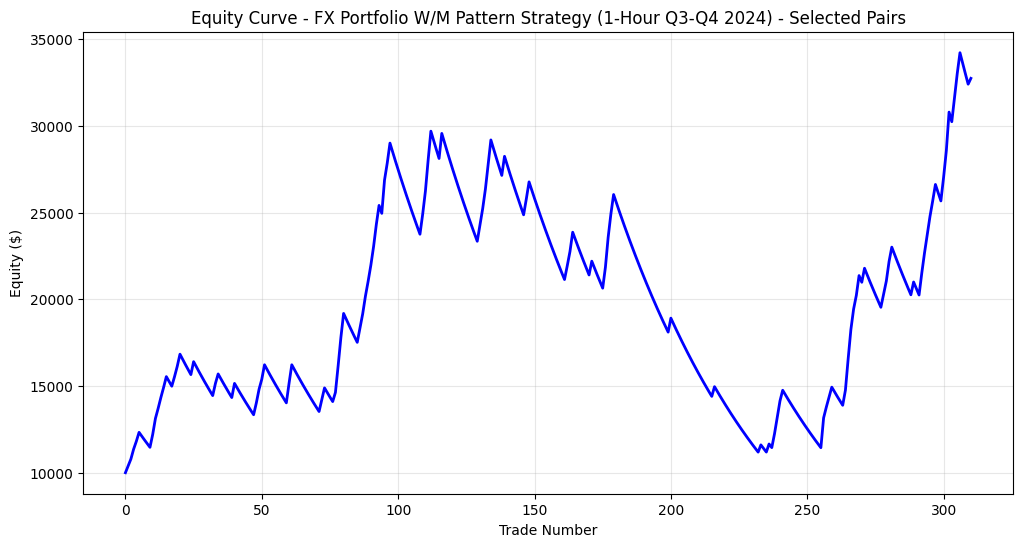

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")
# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q3-Q4 2024 (H1 timeframe)...")
# List of selected FX pairs based on performance notes
symbols = [
    "GBPCAD=X", # Consistent top performer
    "GBPJPY=X", # High return and win rate
    "EURJPY=X", # Huge positive swing in second set
    "GBPAUD=X", # Reliable in both with strong upside
    "EURAUD=X", # Strong gain and high win rate
    "AUDNZD=X", # Big reversal, promising in latest round
    "NZDUSD=X", # Significant turnaround, watch position sizing
    "USDCAD=X", # Mid-level stable performer
    "EURGBP=X", # Consistent small gains, high win rate
    "GBPUSD=X"  # Balanced with good win rate
]
# Download data from July 1, 2024 to December 31, 2024 (Q3 and Q4)
start_date = "2024-07-01"
end_date = "2024-12-31"
# Dictionary to store data for each symbol
all_data = {}
# ======================
# 2. DOWNLOAD AND PREPARE DATA (H1)
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 1-hour data...")
    data = yf.download(symbol, interval="1h", start=start_date, end=end_date)
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    # Store the cleaned data
    all_data[symbol] = data
if not all_data:
    print("❌ No data available for any symbol. Exiting.")
    exit()
print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols (H1).")
# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])
# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data
# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None
def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None
# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob
def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob
# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None
def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None
# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result
# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS
# ======================
all_trades = []
print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols (H1)...")
for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)
# ======================
# 9. BACKTEST EXECUTION
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades (H1)...")
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        # Fix for Max Drawdown calculation
        # Track peak equity for drawdown calculation
        peak_equity = backtester.initial_capital
        max_dd_value = 0
        for equity in backtester.equity_curve:
             if equity > peak_equity:
                 peak_equity = equity
             dd = peak_equity - equity
             if dd > max_dd_value:
                 max_dd_value = dd
        max_drawdown = (max_dd_value / backtester.initial_capital) * 100 if backtester.initial_capital > 0 else 0
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q3-Q4 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        # Save detailed results
        # Updated filename for Q3-Q4 2024
        trade_results.to_csv("portfolio_backtest_fx_h1_q3q4_2024_detailed_results_selected_pairs.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_h1_q3q4_2024_detailed_results_selected_pairs.csv'")
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")
# ======================
# 11. EQUITY CURVE VISUALIZATION
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        # Updated plot title for Q3-Q4 2024
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (1-Hour Q3-Q4 2024) - Selected Pairs')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        # Updated filename for Q3-Q4 2024
        plt.savefig('portfolio_equity_curve_fx_h1_q3q4_2024_selected_pairs.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_h1_q3q4_2024_selected_pairs.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")


📅 Downloading FX data for Q1-Q2 2024 (H1 timeframe)...


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

💾 Data downloaded for 10 symbols (H1).


🔍 Scanning for W/M setups across 10 symbols (H1)...
  Scanning GBPCAD=X (3077 candles)...
    Found 34 trades for GBPCAD=X
  Scanning GBPJPY=X (3061 candles)...
    Found 29 trades for GBPJPY=X
  Scanning EURJPY=X (3060 candles)...
    Found 40 trades for EURJPY=X
  Scanning GBPAUD=X (3078 candles)...
    Found 13 trades for GBPAUD=X
  Scanning EURAUD=X (3062 candles)...
    Found 14 trades for EURAUD=X
  Scanning AUDNZD=X (3078 candles)...
    Found 8 trades for AUDNZD=X
  Scanning NZDUSD=X (3079 candles)...
    Found 33 trades for NZDUSD=X
  Scanning USDCAD=X (3075 candles)...
    Found 31 trades for USDCAD=X
  Scanning EURGBP=X (3062 candles)...
    Found 5 trades for EURGBP=X
  Scanning GBPUSD=X (3061 candles)...
    Found 49 trades for GBPUSD=X
📊 Backtesting 256 total trades (H1)...

📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q1-Q2 2024)
Initial Capital: $10,000.00
Final Capital: $301,616.68
Total Return: $291,616.71 (2916.17%)
Total Trades: 256
Win Rate: 44.5%
Winning Trades: 1

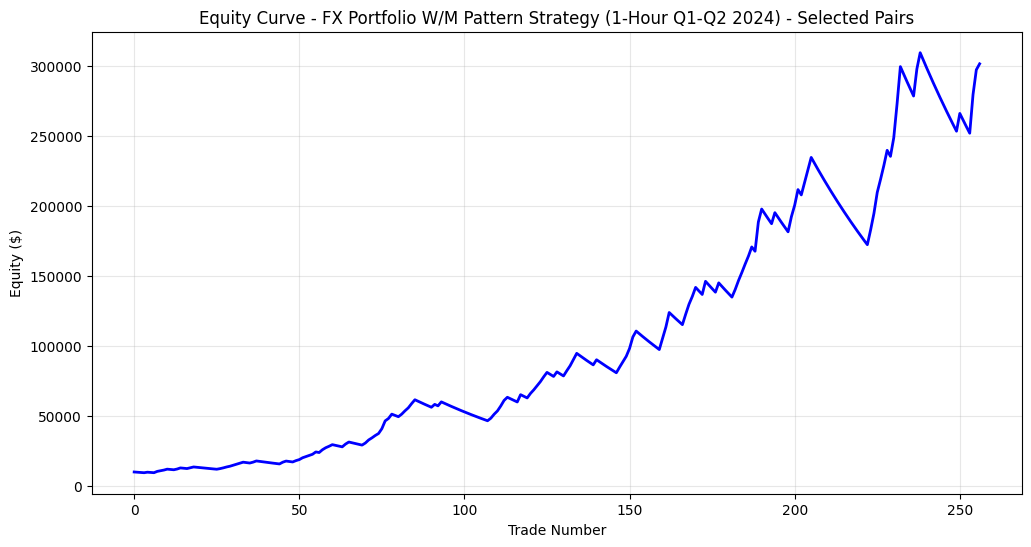

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")
# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q1-Q2 2024 (H1 timeframe)...")
# List of selected FX pairs based on performance notes
symbols = [
    "GBPCAD=X", # Consistent top performer
    "GBPJPY=X", # High return and win rate
    "EURJPY=X", # Huge positive swing in second set
    "GBPAUD=X", # Reliable in both with strong upside
    "EURAUD=X", # Strong gain and high win rate
    "AUDNZD=X", # Big reversal, promising in latest round
    "NZDUSD=X", # Significant turnaround, watch position sizing
    "USDCAD=X", # Mid-level stable performer
    "EURGBP=X", # Consistent small gains, high win rate
    "GBPUSD=X"  # Balanced with good win rate
]
# Download data from January 1, 2024 to June 30, 2024 (Q1 and Q2)
start_date = "2024-01-01"
end_date = "2024-06-30"
# Dictionary to store data for each symbol
all_data = {}
# ======================
# 2. DOWNLOAD AND PREPARE DATA (H1)
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 1-hour data...")
    data = yf.download(symbol, interval="1h", start=start_date, end=end_date)
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    # Store the cleaned data
    all_data[symbol] = data
if not all_data:
    print("❌ No data available for any symbol. Exiting.")
    exit()
print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols (H1).")
# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])
# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data
# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None
def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None
# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob
def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob
# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None
def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None
# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result
# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS
# ======================
all_trades = []
print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols (H1)...")
for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)
# ======================
# 9. BACKTEST EXECUTION
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades (H1)...")
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        # Fix for Max Drawdown calculation
        # Track peak equity for drawdown calculation
        peak_equity = backtester.initial_capital
        max_dd_value = 0
        for equity in backtester.equity_curve:
             if equity > peak_equity:
                 peak_equity = equity
             dd = peak_equity - equity
             if dd > max_dd_value:
                 max_dd_value = dd
        max_drawdown = (max_dd_value / backtester.initial_capital) * 100 if backtester.initial_capital > 0 else 0
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q1-Q2 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        # Save detailed results
        trade_results.to_csv("portfolio_backtest_fx_h1_q1q2_2024_detailed_results_selected_pairs.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_h1_q1q2_2024_detailed_results_selected_pairs.csv'")
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")
# ======================
# 11. EQUITY CURVE VISUALIZATION
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (1-Hour Q1-Q2 2024) - Selected Pairs')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('portfolio_equity_curve_fx_h1_q1q2_2024_selected_pairs.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_h1_q1q2_2024_selected_pairs.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")


📅 Downloading FX data for Q1-Q2 2024 (H1 timeframe)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


💾 Data downloaded for 6 symbols (H1).
🔍 Scanning for W/M setups across 6 symbols (H1)...
  Scanning GBPUSD=X (3061 candles)...
    Found 49 trades for GBPUSD=X
  Scanning EURGBP=X (3062 candles)...
    Found 5 trades for EURGBP=X
  Scanning EURAUD=X (3062 candles)...
    Found 14 trades for EURAUD=X
  Scanning GBPJPY=X (3061 candles)...
    Found 29 trades for GBPJPY=X
  Scanning USDCAD=X (3075 candles)...
    Found 31 trades for USDCAD=X
  Scanning GBPCAD=X (3077 candles)...
    Found 34 trades for GBPCAD=X
📊 Backtesting 162 total trades (H1)...

📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q1-Q2 2024)
Initial Capital: $10,000.00
Final Capital: $79,285.36
Total Return: $69,285.40 (692.85%)
Total Trades: 162
Win Rate: 44.4%
Winning Trades: 72
Losing Trades: 90
Average Win: $1,576.24
Average Loss: $-491.15
Profit Factor: 2.57
Max Drawdown: 77.03%

----------------------------------------
PER-SYMBOL PERFORMANCE:
----------------------------------------
          trades       pnl  win_rat

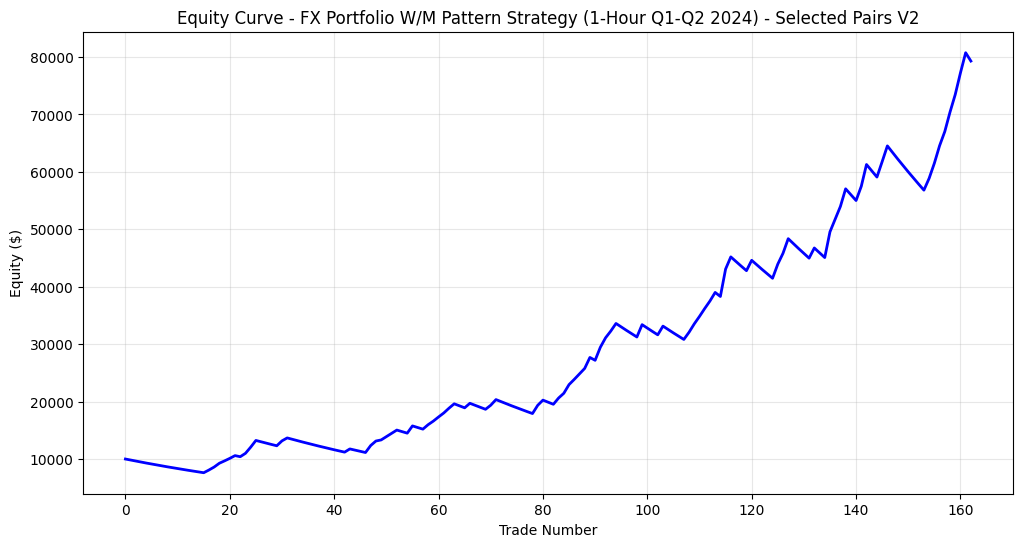

In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")
# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q1-Q2 2024 (H1 timeframe)...")
# List of selected FX pairs
symbols = [
    "GBPUSD=X",   # Gbpusd
    "EURGBP=X",   # Eurgbp
    "EURAUD=X",   # Euraud
    "GBPJPY=X",   # Gbpjpy
    "USDCAD=X",   # Usdcad
    "GBPCAD=X"    # Gbpcad
]
# Download data from January 1, 2024 to June 30, 2024 (Q1 and Q2)
start_date = "2024-01-01"
end_date = "2024-06-30"
# Dictionary to store data for each symbol
all_data = {}
# ======================
# 2. DOWNLOAD AND PREPARE DATA (H1)
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 1-hour data...")
    data = yf.download(symbol, interval="1h", start=start_date, end=end_date)
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    # Store the cleaned data
    all_data[symbol] = data
if not all_data:
    print("❌ No data available for any symbol. Exiting.")
    exit()
print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols (H1).")
# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])
# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data
# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None
def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None
# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob
def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob
# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None
def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None
# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result
# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS
# ======================
all_trades = []
print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols (H1)...")
for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)
# ======================
# 9. BACKTEST EXECUTION
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades (H1)...")
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        # Fix for Max Drawdown calculation
        # Track peak equity for drawdown calculation
        peak_equity = backtester.initial_capital
        max_dd_value = 0
        for equity in backtester.equity_curve:
             if equity > peak_equity:
                 peak_equity = equity
             dd = peak_equity - equity
             if dd > max_dd_value:
                 max_dd_value = dd
        max_drawdown = (max_dd_value / backtester.initial_capital) * 100 if backtester.initial_capital > 0 else 0
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q1-Q2 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        # Save detailed results
        trade_results.to_csv("portfolio_backtest_fx_h1_q1q2_2024_detailed_results_selected_pairs_v2.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_h1_q1q2_2024_detailed_results_selected_pairs_v2.csv'")
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")
# ======================
# 11. EQUITY CURVE VISUALIZATION
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (1-Hour Q1-Q2 2024) - Selected Pairs V2')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('portfolio_equity_curve_fx_h1_q1q2_2024_selected_pairs_v2.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_h1_q1q2_2024_selected_pairs_v2.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")


📅 Downloading FX data for Q3-Q4 2024 (H1 timeframe)...


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

💾 Data downloaded for 6 symbols (H1).


🔍 Scanning for W/M setups across 6 symbols (H1)...
  Scanning GBPUSD=X (3092 candles)...
    Found 28 trades for GBPUSD=X
  Scanning EURGBP=X (3095 candles)...
    Found 26 trades for EURGBP=X
  Scanning EURAUD=X (3096 candles)...
    Found 21 trades for EURAUD=X
  Scanning GBPJPY=X (3093 candles)...
    Found 62 trades for GBPJPY=X
  Scanning USDCAD=X (3110 candles)...
    Found 27 trades for USDCAD=X
  Scanning GBPCAD=X (3103 candles)...
    Found 50 trades for GBPCAD=X
📊 Backtesting 214 total trades (H1)...

📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q3-Q4 2024)
Initial Capital: $10,000.00
Final Capital: $85,961.71
Total Return: $75,961.70 (759.62%)
Total Trades: 214
Win Rate: 40.2%
Winning Trades: 86
Losing Trades: 128
Average Win: $2,032.10
Average Loss: $-771.87
Profit Factor: 1.77
Max Drawdown: 195.12%

----------------------------------------
PER-SYMBOL PERFORMANCE:
----------------------------------------
          trades       pnl  win_rate
symbol                           

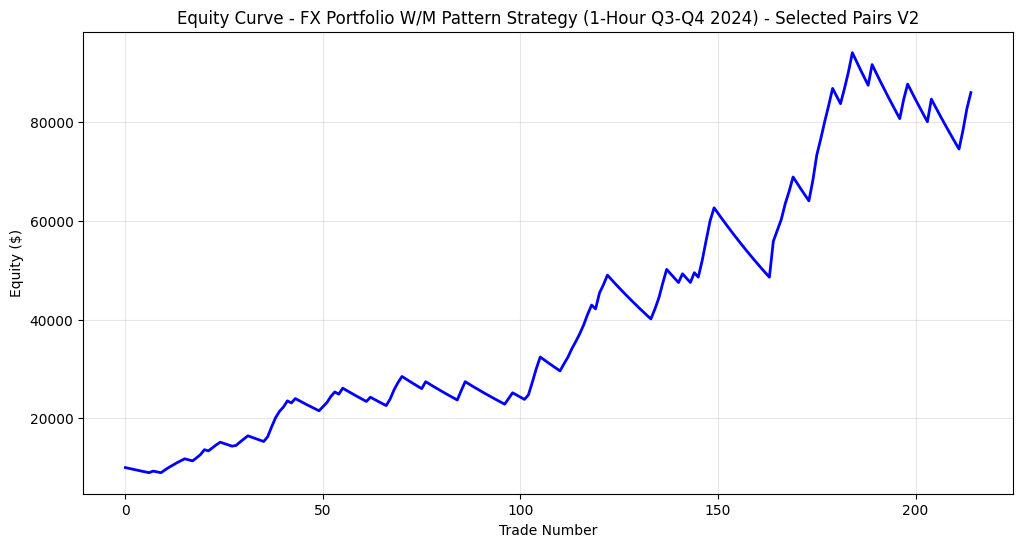

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")
# ======================
# 1. CONFIGURATION
# ======================
print("\U0001F4C5 Downloading FX data for Q3-Q4 2024 (H1 timeframe)...")
# List of selected FX pairs
symbols = [
    "GBPUSD=X",   # Gbpusd
    "EURGBP=X",   # Eurgbp
    "EURAUD=X",   # Euraud
    "GBPJPY=X",   # Gbpjpy
    "USDCAD=X",   # Usdcad
    "GBPCAD=X"    # Gbpcad
]
# Download data from July 1, 2024 to December 31, 2024 (Q3 and Q4)
start_date = "2024-07-01"
end_date = "2024-12-31"
# Dictionary to store data for each symbol
all_data = {}
# ======================
# 2. DOWNLOAD AND PREPARE DATA (H1)
# ======================
for symbol in symbols:
    print(f"Downloading {symbol} 1-hour data...")
    data = yf.download(symbol, interval="1h", start=start_date, end=end_date)
    if data.empty:
        print(f"❌ No data returned for {symbol}. Skipping.")
        continue
    # Clean columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data[['Open', 'High', 'Low', 'Close']]
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['Date'] if 'Date' in data else data.index)
    # Store the cleaned data
    all_data[symbol] = data
if not all_data:  # <-- Corrected line: Added the missing colon ':'
    print("❌ No data available for any symbol. Exiting.")
    exit()
print(f"\U0001F4BE Data downloaded for {len(all_data)} symbols (H1).")
# ======================
# 3. INDICATOR CALCULATIONS (RSI, SWINGS)
# ======================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def find_swings(series, order=3):
    min_idx = argrelextrema(series.values, np.less_equal, order=order)[0]
    max_idx = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return sorted([i for i in min_idx if i < len(series)]), sorted([i for i in max_idx if i < len(series)])
# Apply indicators to all data
for symbol, data in all_data.items():
    # Calculate RSI
    data['RSI'] = compute_rsi(data['Close'])
    data.dropna(inplace=True)
    # Find swings will be done per symbol during pattern detection
    # Store the data back
    all_data[symbol] = data
# ======================
# 4. PATTERN DETECTION
# ======================
def is_w_pattern(data, i, min_indices, window=15):
    start = max(i - window, 0)
    troughs = [idx for idx in min_indices if start <= idx < i]
    if len(troughs) < 2:
        return False, None, None
    t1, t2 = troughs[-2], troughs[-1]
    try:
        low1 = float(data['Low'].iloc[t1])
        low2 = float(data['Low'].iloc[t2])
        rsi1 = float(data['RSI'].iloc[t1])
        rsi2 = float(data['RSI'].iloc[t2])
    except:
        return False, None, None
    price_ok = low2 >= low1 * 0.997
    rsi_ok = (rsi2 > rsi1) and ((rsi2 - rsi1) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['High'].iloc[t1:t2].max()
        return True, neckline, (t1, t2)
    return False, None, None
def is_m_pattern(data, i, max_indices, window=15):
    start = max(i - window, 0)
    peaks = [idx for idx in max_indices if start <= idx < i]
    if len(peaks) < 2:
        return False, None, None
    p1, p2 = peaks[-2], peaks[-1]
    try:
        high1 = float(data['High'].iloc[p1])
        high2 = float(data['High'].iloc[p2])
        rsi1 = float(data['RSI'].iloc[p1])
        rsi2 = float(data['RSI'].iloc[p2])
    except:
        return False, None, None
    price_ok = high2 <= high1 * 1.003
    rsi_ok = (rsi2 < rsi1) and ((rsi1 - rsi2) >= 2.2)
    if price_ok and rsi_ok:
        neckline = data['Low'].iloc[p1:p2].min()
        return True, neckline, (p1, p2)
    return False, None, None
# ======================
# 5. ORDER BLOCK (OB) DETECTION
# ======================
def find_bullish_ob(data, start, end):
    window = data.iloc[start:end]
    bullish_candles = window[(window['Close'] > window['Open'])]
    if bullish_candles.empty:
        return None
    ob = bullish_candles.loc[bullish_candles['Open'].idxmin()]
    return ob
def find_bearish_ob(data, start, end):
    window = data.iloc[start:end]
    bearish_candles = window[(window['Close'] < window['Open'])]
    if bearish_candles.empty:
        return None
    ob = bearish_candles.loc[bearish_candles['Open'].idxmax()]
    return ob
# ======================
# 6. SWING HIGH/LOW FOR TP
# ======================
def find_prior_swing_high(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['High'].iloc[start:from_idx]
    return subset.max() if not subset.empty else None
def find_prior_swing_low(data, from_idx, lookback=22):
    start = max(from_idx - lookback, 0)
    subset = data['Low'].iloc[start:from_idx]
    return subset.min() if not subset.empty else None
# ======================
# 7. BACKTESTING ENGINE
# ======================
class Backtester:
    def __init__(self, all_data, initial_capital=10000, risk_percent=1.8):
        self.all_data = all_data  # Dictionary of data for all symbols
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.risk_percent = risk_percent
        self.trades = []
        self.equity_curve = [initial_capital]
        self.trade_log = []
    def calculate_position_size(self, entry, sl, direction):
        """Calculate position size based on risk percentage"""
        risk_amount = self.capital * (self.risk_percent / 100)
        if direction == 'bull':
            risk_per_unit = abs(entry - sl)
        else:  # bear
            risk_per_unit = abs(sl - entry)
        if risk_per_unit == 0:
            return 0
        position_size = risk_amount / risk_per_unit
        return position_size
    def execute_trade(self, trade_setup):
        """Execute a single trade and update capital"""
        symbol = trade_setup['symbol']
        data = self.all_data[symbol]
        entry_idx = data[data['timestamp'] == trade_setup['timestamp']].index[0]
        # Simulate trade execution
        entry_price = trade_setup['entry']
        sl_price = trade_setup['sl']
        tp_price = trade_setup['tp']
        direction = trade_setup['direction']
        # Calculate position size
        position_size = self.calculate_position_size(entry_price, sl_price, direction)
        if position_size <= 0:
            return None
        # Track trade progress
        exit_price = None
        exit_reason = None
        exit_timestamp = None
        pnl = 0
        rr_ratio = 0
        # Simulate trade through subsequent candles
        for i in range(entry_idx + 1, len(data)):
            current_candle = data.iloc[i]
            # Check for stop loss hit
            if direction == 'bull' and current_candle['Low'] <= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['High'] >= sl_price:
                exit_price = sl_price
                exit_reason = 'SL'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
            # Check for take profit hit
            if direction == 'bull' and current_candle['High'] >= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (exit_price - entry_price) * position_size
                rr_ratio = abs((tp_price - entry_price) / (entry_price - sl_price))
                break
            elif direction == 'bear' and current_candle['Low'] <= tp_price:
                exit_price = tp_price
                exit_reason = 'TP'
                exit_timestamp = current_candle['timestamp']
                pnl = (entry_price - exit_price) * position_size
                rr_ratio = abs((entry_price - tp_price) / (sl_price - entry_price))
                break
        # If trade is still open at the end, close at market
        if exit_price is None and entry_idx + 1 < len(data):
            final_candle = data.iloc[-1]
            exit_price = final_candle['Close']
            exit_reason = 'Market Close'
            exit_timestamp = final_candle['timestamp']
            if direction == 'bull':
                pnl = (exit_price - entry_price) * position_size
            else:
                pnl = (entry_price - exit_price) * position_size
        # Update capital
        self.capital += pnl
        self.equity_curve.append(self.capital)
        # Create detailed trade record
        trade_result = {
            **trade_setup,
            'exit_price': round(exit_price, 5) if exit_price else None,
            'exit_reason': exit_reason,
            'exit_timestamp': exit_timestamp,
            'position_size': round(position_size, 2),
            'pnl': round(pnl, 2),
            'rr_ratio': round(rr_ratio, 2) if rr_ratio else 0,
            'capital_after_trade': round(self.capital, 2)
        }
        self.trade_log.append(trade_result)
        return trade_result
# ======================
# 8. TRADE LOGIC - SCAN ALL SYMBOLS
# ======================
all_trades = []
print(f"\U0001F50D Scanning for W/M setups across {len(all_data)} symbols (H1)...")
for symbol, data in all_data.items():
    print(f"  Scanning {symbol} ({len(data)} candles)...")
    # Find swings for this symbol
    min_idx_list, max_idx_list = find_swings(data['Low'], order=3)
    trades = []
    for i in range(25, len(data) - 2):
        # --- W PATTERN ---
        is_w, neckline_w, troughs = is_w_pattern(data, i, min_idx_list)
        if is_w and data['High'].iloc[i] > neckline_w:
            ob = find_bullish_ob(data, troughs[1], i)
            if ob is not None and data['Close'].iloc[i] > ob['High']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['Low'] - 0.0005
                tp = find_prior_swing_high(data, i)
                rr = (tp - entry) / (entry - sl) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bull',
                        'setup': 'W_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
        # --- M PATTERN ---
        is_m, neckline_m, peaks = is_m_pattern(data, i, max_idx_list)
        if is_m and data['Low'].iloc[i] < neckline_m:
            ob = find_bearish_ob(data, peaks[1], i)
            if ob is not None and data['Close'].iloc[i] < ob['Low']:
                entry_idx = i + 1
                if entry_idx >= len(data): continue
                entry = data['Open'].iloc[entry_idx]
                sl = ob['High'] + 0.0005
                tp = find_prior_swing_low(data, i)
                rr = (entry - tp) / (sl - entry) if tp is not None else 0
                if tp is not None and rr >= 2:
                    trades.append({
                        'symbol': symbol,
                        'timestamp': data['timestamp'].iloc[entry_idx],
                        'entry': round(entry, 5),
                        'sl': round(sl, 5),
                        'tp': round(tp, 5),
                        'direction': 'bear',
                        'setup': 'M_pattern',
                        'ob_time': ob['timestamp'] if 'timestamp' in ob else ob.name
                    })
    print(f"    Found {len(trades)} trades for {symbol}")
    all_trades.extend(trades)
# ======================
# 9. BACKTEST EXECUTION
# ======================
if all_trades:
    print(f"\U0001F4CA Backtesting {len(all_trades)} total trades (H1)...")
    # Initialize backtester
    backtester = Backtester(all_data, initial_capital=10000, risk_percent=1.8)
    # Execute all trades
    for trade in all_trades:
        backtester.execute_trade(trade)
    # ======================
    # 10. PERFORMANCE METRICS
    # ======================
    if backtester.trade_log:
        trade_results = pd.DataFrame(backtester.trade_log)
        # Calculate metrics
        total_trades = len(trade_results)
        winning_trades = trade_results[trade_results['pnl'] > 0]
        losing_trades = trade_results[trade_results['pnl'] < 0]
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        total_pnl = trade_results['pnl'].sum()
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        profit_factor = abs(winning_trades['pnl'].sum() / losing_trades['pnl'].sum()) if len(losing_trades) > 0 else float('inf')
        max_equity = max(backtester.equity_curve)
        min_equity = min(backtester.equity_curve)
        # Fix for Max Drawdown calculation
        # Track peak equity for drawdown calculation
        peak_equity = backtester.initial_capital
        max_dd_value = 0
        for equity in backtester.equity_curve:
             if equity > peak_equity:
                 peak_equity = equity
             dd = peak_equity - equity
             if dd > max_dd_value:
                 max_dd_value = dd
        max_drawdown = (max_dd_value / backtester.initial_capital) * 100 if backtester.initial_capital > 0 else 0
        # Strategy performance
        roi = ((backtester.capital - backtester.initial_capital) / backtester.initial_capital) * 100
        # Per-symbol performance
        symbol_performance = trade_results.groupby('symbol').agg(
            trades=('pnl', 'count'),
            pnl=('pnl', 'sum'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100)
        ).round(2)
        # Print results
        print("\n" + "="*60)
        print("📊 PORTFOLIO BACKTESTING RESULTS - FX 1-HOUR (Q3-Q4 2024)")
        print("="*60)
        print(f"Initial Capital: ${backtester.initial_capital:,.2f}")
        print(f"Final Capital: ${backtester.capital:,.2f}")
        print(f"Total Return: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}%")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Average Win: ${avg_win:,.2f}")
        print(f"Average Loss: ${avg_loss:,.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-"*40)
        print("PER-SYMBOL PERFORMANCE:")
        print("-"*40)
        print(symbol_performance.to_string())
        # Save detailed results
        trade_results.to_csv("portfolio_backtest_fx_h1_q3q4_2024_detailed_results_selected_pairs_v2.csv", index=False)
        print(f"\n✅ Detailed results saved to 'portfolio_backtest_fx_h1_q3q4_2024_detailed_results_selected_pairs_v2.csv'")
        # Show last 10 trades
        print("\n📋 Last 10 Trades:")
        print(trade_results[['symbol', 'timestamp', 'direction', 'entry', 'sl', 'tp', 'pnl', 'rr_ratio', 'exit_reason']].tail(10).to_string(index=False))
    else:
        print("❌ No trades were executed during backtest.")
else:
    print("❌ No trades found for backtesting.")
# ======================
# 11. EQUITY CURVE VISUALIZATION
# ======================
try:
    import matplotlib.pyplot as plt
    if hasattr(backtester, 'equity_curve') and len(backtester.equity_curve) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(backtester.equity_curve, linewidth=2, color='blue')
        plt.title('Equity Curve - FX Portfolio W/M Pattern Strategy (1-Hour Q3-Q4 2024) - Selected Pairs V2')
        plt.xlabel('Trade Number')
        plt.ylabel('Equity ($)')
        plt.grid(True, alpha=0.3)
        plt.savefig('portfolio_equity_curve_fx_h1_q3q4_2024_selected_pairs_v2.png', dpi=300, bbox_inches='tight')
        print("📈 Equity curve saved as 'portfolio_equity_curve_fx_h1_q3q4_2024_selected_pairs_v2.png'")
        # plt.show()  # Uncomment to display plot
except ImportError:
    print("💡 Install matplotlib for equity curve visualization: pip install matplotlib")
